In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from lettuce.boundary import EquilibriumBoundaryPU, EquilibriumOutletP, AntiBounceBackOutlet
from lettuce.observables import Observable
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce import ObstacleMax3D
from lettuce.flows.obstacleCylinder import ObstacleCylinder
import torch
import time
import datetime
import os
import psutil
import shutil
from pyevtk.hl import imageToVTK

In [5]:
### OUTPUT SETTINGS
output_data = True
output_vtk = False # is overwritten with False if output_data=False (see below)
vtk_fps = 10
calculate_velocity_profile = False  # outputs plots and time-averaged data for plots
output_velocity_profile = False  # outputs the full time series (!)

# IMPORTANT: set correct output_path, for example "/home/YourUserName/simulation_output"
#output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
#output_path = "/home/mbille3s/02_lbm_simulations"  # cluster HBRS

# IMPORTANT: set correct input_path for reference data:
diIlio_path = '/home/mbille/lettuce/myTest/DiIlio_data/'  # likal HBRS
# diIlio_path = '/scratch/mbille3s/21_LBM/03_reference_data/DiIlio_2018/'  # cluster HBRS

# name: if you want something specific in the dir-name
name = "cyl3D_sparse_hybrid_v2"

# choose stencil: "D3Q9" dor 2D, "D3Q15", "D3Q19", "D3Q27" for 3D
stencil_choice = "D3Q27"
# choose collision operator: "bgk, "kbc", "reg"
collision_choice = "bgk"

In [6]:
### SIMULATION PARAMETERS (and estimation of timesteps needed to reach T_target)
re = 200   # Reynoldsnumber
Ma = 0.05     # Machnumber
n_steps = 1 #100 #145492 # number of steps
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_pu -> this defines the PU-Reference velocity (u_max of inflow)

# relative starting point for drag-measurement (make sure periodic state is reached)
periodic_start = 0.9  # relative start of peak_finding for Cd_mean Measurement to cut of any transients

# GEOMETRY
gridpoints_per_diameter = 50  # gp_per_D = GPD -> this defines the resolution ( D_LU = GPD)
domain_height_in_D = 1  # D/Y = DpY = diameters per domain width in Y-direction -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2 * domain_height_in_D  # D/X = domain length in X- / flow-direction
domain_width_in_D = 1#3 #domain_height_in_D #1/gridpoints_per_diameter  # D/Z = DpZ = diameters per domain width in Z-direction -> domain size in periodic 3rd dimension

# RELATION [GPD to DpY] check
# if DpY is even, resulting GPD can't be odd for symmetrical cylinder and channel
# ...if DpY is even, GPD will be corrected to even GPD for symmetrical cylinder
# ...use odd DpY to use odd GPD
gpd_correction=False
if domain_height_in_D % 2 == 0 and gridpoints_per_diameter % 2 != 0:
    gpd_correction = True   # gpd_was_corrected-flag
    gpd_setup = gridpoints_per_diameter   # store old gpd for output
    gridpoints_per_diameter = int(gridpoints_per_diameter/2)*2   # make gpd even
    print("(!) domain_height_in_D is even, gridpoints_per_diameter will be "+str(gridpoints_per_diameter)+". Use odd domain_height_in_D to enable use of odd GPD!")

# SIMULATOR settings
u_init = 0    # initial velocity field: # 0: uniform u=0, # 1: uniform u=1, # 2: parabolic, amplitude u_char_lu (similar to poiseuille-flow)
perturb_init = True   # perturb initial symmetry by small sine-wave in initial velocity field -> triggers Karman-vortex street for Re > 46
lateral_walls='periodic'  # type of top/bottom boundary: 'bounceback' = frictious wall, 'periodic' = periodic boundary, 'slip' = non-frictious wall
bc_type='ibb1'  # choose algorithm for bounceback-boundaries: fullway 'fwbb', halfway 'hwbb', linear interpolated 'ibb1'

# T_PU to n_steps estimation: (for example for Re=200 the periodic state is reached for T_PU > 140)
T_target=200
print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_height_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", round(n_steps * (setup_diameter/(gridpoints_per_diameter))*(Ma*1/np.sqrt(3)/flow_velocity),2), "seconds")
print("n_steps to simulate 1 second:", round(((gridpoints_per_diameter)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")
print("n_steps to simulate",T_target,"seconds:",T_target*round(((gridpoints_per_diameter)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")


mlups_2060super = 20
mlups_2080ti = 30   # 40 for GPD30,DpY19,nsteps=150000 (steigend mit der Auflösung)

if output_vtk:
    print("generates approx.", int(vtk_fps*(n_steps * (setup_diameter/(gridpoints_per_diameter))*(Ma*1/np.sqrt(3)/flow_velocity)))+1, ".vti/.vtk-frames")

gridpoints = gridpoints_per_diameter**3*domain_length_in_D*domain_height_in_D*domain_width_in_D
print("No. of gridpoints:", gridpoints)

shape_LU: 100 x 50 x 50
T with 1 steps: 0.0 seconds
n_steps to simulate 1 second: 1732.05 steps
n_steps to simulate 200 seconds: 346410.0 steps
No. of gridpoints: 250000


In [7]:
### (no user input) CREATE OUTPUT DIRECTORIES
if output_data:  # toggle output
    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    dir_name = "/data_" + str(timestamp) + "_" + name + "_GPD" + str(gridpoints_per_diameter) + "_" + str(domain_length_in_D) + "x" + str(domain_height_in_D) + "x" + str(domain_width_in_D) + "_" + str(stencil_choice)

    os.makedirs(output_path+dir_name)

    if output_vtk:
        vtk_path = output_path+dir_name+"/vtk/out"
        print("vtk_path: " + vtk_path)
    print("dir_name: "+dir_name)

    if calculate_velocity_profile:
        os.makedirs(output_path+dir_name+"/AvgVelocity_Data")
else:
    output_vtk = False

dir_name: /data_231003_150739_cyl3D_sparse_hybrid_v2_GPD50_2x1x1_D3Q27


In [8]:
logVRAM=False
if logVRAM:
    def log_VRAM(title):
        timestamp1 = datetime.datetime.now()
        timestamp1 = timestamp1.strftime("%y%m%d")+"_"+timestamp1.strftime("%H%M%S")+"_"+timestamp1.strftime("%f")
        vram_history_file.write(str(title).ljust(40) + ";"# + "; timestamp, c, p;   "
                          + str(timestamp1).rjust(22) + ";"
                          + str(round(torch.cuda.memory_allocated(device="cuda:0") / 1024 / 1024, 2)).rjust(10) + ";"
                          + str(round(torch.cuda.max_memory_allocated(device="cuda:0") / 1024 / 1024, 2)).rjust(10) + ";"
                          )
        torch.cuda.reset_peak_memory_stats()
        timestamp1 = datetime.datetime.now()
        timestamp1 = timestamp1.strftime("%y%m%d")+"_"+timestamp1.strftime("%H%M%S")
        vram_history_file.write(str(timestamp1).rjust(22) + "\n")
else:
    def log_VRAM(title):
        pass

In [9]:
# timestamp1 = datetime.datetime.now()
# timestamp1 = timestamp1.strftime("%y%m%d")+"_"+timestamp1.strftime("%H%M%S")

if logVRAM:
    vram_history_file = open(output_path+dir_name+"/"+timestamp + "_VRAM_history.txt", "a")
    vram_history_file.write("DATA FOR: " + str(timestamp) + "_" + name + "_GPD" + str(gridpoints_per_diameter) + "_" + str(domain_length_in_D) + "x" + str(domain_height_in_D) + "x" + str(domain_width_in_D) + "_" + str(stencil_choice) + "\n\n")
    vram_history_file.write("title".ljust(40) +";"+"timestep_pre".rjust(22)+";"+"cVRAM [MB]".rjust(10)+";"+"pVRAM [MB]".rjust(10)+";"+ "timestep_post".rjust(22) + "\n")

# timestamp1 = datetime.datetime.now()
# timestamp1 = timestamp1.strftime("%y%m%d")+"_"+timestamp1.strftime("%H%M%S")
# vram_history_file.write("START; timestamp, c, p;".ljust(30)
#                   + str(timestamp1) + ";   "
#                   + str(round(torch.cuda.memory_allocated(device="cuda:0") / 1024 / 1024, 2)).rjust(10) + ";   "
#                   + str(round(torch.cuda.max_memory_allocated(device="cuda:0") / 1024 / 1024, 2)).rjust(10)
#                  +"\n")
# torch.cuda.reset_peak_memory_stats(device="cuda:0")
log_VRAM("start")

# Modified Classes

### Lattice

In [10]:
import warnings
class Lattice:

    def __init__(self, stencil, device, dtype=torch.float):
        self.stencil = stencil
        self.device = device
        self.dtype = dtype
        self.e = self.convert_to_tensor(stencil.e)
        self.w = self.convert_to_tensor(stencil.w)
        self.cs = self.convert_to_tensor(stencil.cs)
        self.equilibrium = QuadraticEquilibrium(self)

    def __str__(self):
        return f"Lattice (stencil {self.stencil.__name__}; device {self.device}; dtype {self.dtype})"

    @property
    def D(self):
        return self.stencil.e.shape[1]

    @property
    def Q(self):
        return self.stencil.e.shape[0]

    def convert_to_tensor(self, array):

        def is_bool_array(it):
            return (isinstance(it, torch.BoolTensor) or
                    (isinstance(it, np.ndarray) and it.dtype in [bool, np.uint8]))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            if is_bool_array(array):
                return torch.tensor(array, device=self.device, dtype=torch.bool)
            else:
                return torch.tensor(array, device=self.device, dtype=self.dtype)

    @classmethod
    def convert_to_numpy(cls, tensor):
        return tensor.detach().cpu().numpy()

    def rho(self, f):
        """density"""
        return torch.sum(f, dim=0)[None, ...]

    def j(self, f):
        """momentum"""
        return self.einsum("qd,q->d", [self.e, f])

    def u(self, f, rho=None, acceleration=None):
        """velocity; the `acceleration` is used to compute the correct velocity in the presence of a forcing scheme."""
        if rho is None:
            rho = self.rho(f)
        v = self.j(f) / rho
        # apply correction due to forcing, which effectively averages the pre- and post-collision velocity
        correction = 0.0
        if acceleration is not None:
            if len(acceleration.shape) == 1:
                index = [Ellipsis] + [None]*self.D
                acceleration = acceleration[index]
            correction = acceleration / (2 * rho)
        return v + correction

    def incompressible_energy(self, f):
        """incompressible kinetic energy"""
        return 0.5 * self.einsum("d,d->", [self.u(f), self.u(f)])

    def entropy(self, f):
        """entropy according to the H-theorem"""
        f_log = -torch.log(self.einsum("q,q->q", [f, 1 / self.w]))
        return self.einsum("q,q->", [f, f_log])

    def pseudo_entropy_global(self, f):
        """pseudo_entropy derived by a Taylor expansion around the weights"""
        f_w = self.einsum("q,q->q", [f, 1 / self.w])
        return self.rho(f) - self.einsum("q,q->", [f, f_w])

    def pseudo_entropy_local(self, f):
        """pseudo_entropy derived by a Taylor expansion around the local equilibrium"""
        f_feq = f / self.equilibrium(self.rho(f), self.u(f))
        return self.rho(f) - self.einsum("q,q->", [f, f_feq])

    def shear_tensor(self, f):
        """computes the shear tensor of a given f in the sense Pi_{\alpha \beta} = f_i * e_{i \alpha} * e_{i \beta}"""
        shear = self.einsum("qa,qb->qab", [self.e, self.e])
        shear = self.einsum("q,qab->ab", [f, shear])
        return shear

    def mv(self, m, v):
        """matrix-vector multiplication"""
        return self.einsum("ij,j->i", [m, v])

    def einsum(self, equation, fields, **kwargs):
        """Einstein summation on local fields."""
        input, output = equation.split("->")
        inputs = input.split(",")
        for i, inp in enumerate(inputs):
            if len(inp) == len(fields[i].shape):
                pass
            elif len(inp) == len(fields[i].shape) - self.D:
                inputs[i] += "..."
                if not output.endswith("..."):
                    output += "..."
            else:
                raise LettuceException("Bad dimension.")
        equation = ",".join(inputs) + "->" + output
        return torch.einsum(equation, fields, **kwargs)


## Equilibrium

In [11]:
class Equilibrium:
    pass


class QuadraticEquilibrium(Equilibrium):
    def __init__(self, lattice):
        self.lattice = lattice

    def __call__(self, rho, u, *args):
        log_VRAM("EQ_call_start")
        exu = torch.tensordot(self.lattice.e, u, dims=1)
        uxu = self.lattice.einsum("d,d->", [u, u])
        feq = self.lattice.einsum(
            "q,q->q",
            [self.lattice.w,
             rho * ((2 * exu - uxu) / (2 * self.lattice.cs ** 2) + 0.5 * (exu / (self.lattice.cs ** 2)) ** 2 + 1)]
        )
        log_VRAM("EQ_call_end")
        return feq


class QuadraticEquilibrium_LessMemory(QuadraticEquilibrium):
    """does the same as the normal equilibrium, how ever it uses somewhere around 20% less RAM,
    but runs about 2% slower on GPU and 11% on CPU

    Use this by setting
    lattice.equilibrium = QuadraticEquilibrium_LessMemory(lattice)
    before starting your simulation
    """

    def __call__(self, rho, u, *args):
        log_VRAM("EQ_LM_call_start (no end)")
        return self.lattice.einsum(
            "q,q->q",
            [self.lattice.w,
             rho * ((2 * torch.tensordot(self.lattice.e, u, dims=1) - self.lattice.einsum("d,d->", [u, u]))
                    / (2 * self.lattice.cs ** 2)
                    + 0.5 * (torch.tensordot(self.lattice.e, u, dims=1) / (self.lattice.cs ** 2)) ** 2 + 1)]
        )

## collision & streaming

In [12]:
class BGKCollision:
    def __init__(self, lattice, tau, force=None):
        self.force = force
        self.lattice = lattice
        self.tau = tau

    def __call__(self, f):
        log_VRAM("BGK_call_start")
        rho = self.lattice.rho(f)
        u_eq = 0 if self.force is None else self.force.u_eq(f)
        u = self.lattice.u(f, rho=rho) + u_eq
        feq = self.lattice.equilibrium(rho, u)
        Si = 0 if self.force is None else self.force.source_term(u)
        log_VRAM("BGK_call_end (vor return)")
        return f - 1.0 / self.tau * (f - feq) + Si

class StandardStreaming:

    def __init__(self, lattice):
        self.lattice = lattice
        self._no_stream_mask = None

    @property
    def no_stream_mask(self):
        return self._no_stream_mask

    @no_stream_mask.setter
    def no_stream_mask(self, mask):
        self._no_stream_mask = mask

    def __call__(self, f):
        log_VRAM("Streaming_call_start")
        for i in range(1, self.lattice.Q):
            if self.no_stream_mask is None:
                f[i] = self._stream(f, i)
            else:
                new_fi = self._stream(f, i)
                f[i] = torch.where(self.no_stream_mask[i], f[i], new_fi)
        log_VRAM("Streaming_call_end")
        return f

    def _stream(self, f, i):
        return torch.roll(f[i], shifts=tuple(self.lattice.stencil.e[i]), dims=tuple(np.arange(self.lattice.D)))

## boundary

In [13]:
class InterpolatedBounceBackBoundary:

    def __init__(self, mask, lattice, x_center, y_center, radius, interpolation_order=1):
        log_VRAM("IBB1_init_start")
        t_init_start = time.time()
        self.interpolation_order = interpolation_order
        self.mask = mask  # location of solid-nodes
        self.lattice = lattice
        self.force_sum = torch.zeros_like(self.lattice.convert_to_tensor(
            self.lattice.stencil.e[0]))  # summed force vector on all boundary nodes, in D dimensions (x,y,(z))
        ### create f_mask, needed for force-calculation
        # ...(marks all fs which point from fluid to solid (boundary) and considered for momentum exchange)

        self.f_mask_sequential_gt = []  # coordinates (q,x,y,[z]) for all force- and bounce-relevant populations with d<=0.5
        self.f_mask_sequential_lt = []  # coordinates (q,x,y,[z]) for all force- and bounce-relevant populations with d>0.5
        self.d_sequential_lt = []  # relative "d"istance between the solid node and the ideal boundary location for d<=0.5
        self.d_sequential_gt = []  # relative "d"istance between the solid node and the ideal boundary location for d>0.5

        if self.lattice.D == 2:
            nx, ny = mask.shape  # domain size in x and y
            a, b = np.where(mask)
            # np.arrays: list of (a) x-coordinates and (b) y-coordinates in the boundary.mask
            # ...to enable iteration over all boundary/wall/object-nodes
            for p in range(0, len(a)):  # for all TRUE-nodes in boundary.mask
                for i in range(0, self.lattice.Q):  # for all stencil-directions c_i (lattice.stencil.e in lettuce)
                    # check for boundary-nodes neighboring the domain-border.
                    # ...they have to take the periodicity into account...
                    border = np.zeros(self.lattice.D, dtype=int)
                    if a[p] == 0 and self.lattice.stencil.e[i, 0] == -1:  # searching border on left
                        border[0] = -1
                    elif a[p] == nx - 1 and self.lattice.e[i, 0] == 1:  # searching border on right
                        border[0] = 1
                    if b[p] == 0 and self.lattice.stencil.e[i, 1] == -1:  # searching border on left
                        border[1] = -1
                    elif b[p] == ny - 1 and self.lattice.e[i, 1] == 1:  # searching border on right
                        border[1] = 1
                    try:  # try in case the neighboring cell does not exist (= an f pointing out of the simulation domain)
                        if not mask[a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                    b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny]:
                            # if the neighbour of p is False in the boundary.mask, p is a solid node, neighbouring a fluid node:
                            # ...the direction pointing from the fluid neighbour to solid p is marked on the (fluid) neighbour,
                            # ...(needed for bounce-back (hwbb and ibb1) and force-calculation)

                            # calculate intersection point of boundary surface and link ->
                            # ...calculate distance between fluid node and boundary surface on the link
                            px = a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx  # fluid node x-coordinate
                            py = b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny  # fluid node y-coordinate
                            cx = self.lattice.stencil.e[self.lattice.stencil.opposite[i], 0]  # link-direction x to solid node
                            cy = self.lattice.stencil.e[self.lattice.stencil.opposite[i], 1]  # link-direction y to solid node

                            # pq-formula
                            h1 = (px * cx + py * cy - cx * x_center - cy * y_center) / (cx * cx + cy * cy)  # p/2
                            h2 = (px * px + py * py + x_center * x_center + y_center * y_center
                                  - 2 * px * x_center - 2 * py * y_center - radius * radius) / (cx * cx + cy * cy)  # q

                            d1 = - h1 + np.sqrt(h1 * h1 - h2)
                            d2 = - h1 - np.sqrt(h1 * h1 - h2)

                            #print("xb,yb,i,d1,d2 xf, yf, cx, cy:", a[p], b[p],i,d1,d2,px,py,cx,cy)

                            # distance (LU) from fluid node to the "true" boundary location
                            if d1 <= 1 and np.isreal(d1):  # d should be between 0 and 1
                                if d1 <= 0.5:
                                    self.d_sequential_lt.append(d1)
                                    self.f_mask_sequential_lt.append([self.lattice.stencil.opposite[i],
                                                           a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                                           b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny])
                                else:
                                    self.d_sequential_gt.append(d1)
                                    self.f_mask_sequential_gt.append([self.lattice.stencil.opposite[i],
                                                           a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                                           b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny])
                            elif d2 <= 1 and np.isreal(d2):
                                if d2 <= 0.5:
                                    self.d_sequential_lt.append(d2)
                                    self.f_mask_sequential_lt.append([self.lattice.stencil.opposite[i],
                                                           a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                                           b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny])
                                else:
                                    self.d_sequential_gt.append(d2)
                                    self.f_mask_sequential_gt.append([self.lattice.stencil.opposite[i],
                                                           a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                                           b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny])
                            else:  # if both distances d1, d2 are not between 0 and 1
                                print("IBB WARNING: d1 is", d1,"; d2 is", d2, "for boundaryPoint x,y,ci", a[p],b[p],self.lattice.stencil.e[i, 0],self.lattice.stencil.e[i, 1])
                    except IndexError:
                        pass  # just ignore this iteration since there is no neighbor there
        if self.lattice.D == 3:  # like 2D, but in 3D...guess what...
            nx, ny, nz = mask.shape
            a, b, c = np.where(mask)
            for p in range(0, len(a)):
                for i in range(0, self.lattice.Q):
                    border = np.zeros(self.lattice.D, dtype=int)
                    if a[p] == 0 and self.lattice.stencil.e[i, 0] == -1:  # searching border on left
                        border[0] = -1
                    elif a[p] == nx - 1 and self.lattice.e[i, 0] == 1:  # searching border on right
                        border[0] = 1
                    if b[p] == 0 and self.lattice.stencil.e[i, 1] == -1:  # searching border on left
                        border[1] = -1
                    elif b[p] == ny - 1 and self.lattice.e[i, 1] == 1:  # searching border on right
                        border[1] = 1
                    if c[p] == 0 and self.lattice.stencil.e[i, 2] == -1:  # searching border on left
                        border[2] = -1
                    elif c[p] == nz - 1 and self.lattice.e[i, 2] == 1:  # searching border on right
                        border[2] = 1
                    try:  # try in case the neighboring cell does not exist (an f pointing out of simulation domain)
                        if not mask[a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                    b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny,
                                    c[p] + self.lattice.stencil.e[i, 2] - border[2] * nz]:

                            # calculate intersection point of boundary surface and link ->
                            # ...calculate distance between fluid node and boundary surface on the link
                            px = a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx  # fluid node x-coordinate
                            py = b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny  # fluid node y-coordinate
                            # Z-coodinate not needed for cylinder ! #pz = c[p] + self.lattice.stencil.e[i, 2] - border[2] * nz  # fluid node z-coordinate

                            cx = self.lattice.stencil.e[
                                self.lattice.stencil.opposite[i], 0]  # link-direction x to solid node
                            cy = self.lattice.stencil.e[
                                self.lattice.stencil.opposite[i], 1]  # link-direction y to solid node
                            # Z-coodinate not needed for cylinder ! #cz = self.lattice.stencil.e[
                            #    self.lattice.stencil.opposite[i], 2]  # link-direction z to solid node

                            # pq-formula
                            h1 = (px * cx + py * cy - cx * x_center - cy * y_center) / (cx * cx + cy * cy)  # p/2
                            h2 = (px * px + py * py + x_center * x_center + y_center * y_center
                                  - 2 * px * x_center - 2 * py * y_center - radius * radius) / (cx * cx + cy * cy)  # q

                            d1 = - h1 + np.sqrt(h1 * h1 - h2)
                            d2 = - h1 - np.sqrt(h1 * h1 - h2)

                            #print("xb,yb,i,d1,d2 xf, yf, cx, cy:", a[p], b[p], i, d1, d2, px, py, cx, cy)
                            # distance (LU) from fluid node to the "true" boundary location
                            if d1 <= 1 and np.isreal(d1):  # d should be between 0 and 1
                                if d1 <= 0.5:
                                    self.d_sequential_lt.append(d1)
                                    self.f_mask_sequential_lt.append([self.lattice.stencil.opposite[i],
                                                           a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                                           b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny,
                                                           c[p] + self.lattice.stencil.e[i, 2] - border[2] * nz])
                                else:
                                    self.d_sequential_gt.append(d1)
                                    self.f_mask_sequential_gt.append([self.lattice.stencil.opposite[i],
                                                           a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                                           b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny,
                                                           c[p] + self.lattice.stencil.e[i, 2] - border[2] * nz])
                            elif d2 <= 1 and np.isreal(d2):
                                if d2 <= 0.5:
                                    self.d_sequential_lt.append(d2)
                                    self.f_mask_sequential_lt.append([self.lattice.stencil.opposite[i],
                                                           a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                                           b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny,
                                                           c[p] + self.lattice.stencil.e[i, 2] - border[2] * nz])
                                else:
                                    self.d_sequential_gt.append(d2)
                                    self.f_mask_sequential_gt.append([self.lattice.stencil.opposite[i],
                                                           a[p] + self.lattice.stencil.e[i, 0] - border[0] * nx,
                                                           b[p] + self.lattice.stencil.e[i, 1] - border[1] * ny,
                                                           c[p] + self.lattice.stencil.e[i, 2] - border[2] * nz])
                            else:  # if both distances d1, d2 are not between 0 and 1
                                print("IBB WARNING: d1 is", d1,"; d2 is", d2, "for boundaryPoint x,y,ci", a[p],b[p],c[p],self.lattice.stencil.e[i, 0],self.lattice.stencil.e[i, 1],self.lattice.stencil.e[i, 2])
                    except IndexError:
                        pass  # just ignore this iteration since there is no neighbor there

        self.f_mask_sequential_lt = torch.tensor(np.array(self.f_mask_sequential_lt), device=self.lattice.device, dtype=torch.int64)  # the index has has to be integer
        self.f_mask_sequential_gt = torch.tensor(np.array(self.f_mask_sequential_gt), device=self.lattice.device, dtype=torch.int64)  # the index has has to be integer

        self.d_sequential_lt = self.lattice.convert_to_tensor(np.array(self.d_sequential_lt))
        self.d_sequential_gt = self.lattice.convert_to_tensor(np.array(self.d_sequential_gt))

        self.opposite_tensor = torch.tensor(self.lattice.stencil.opposite, device=self.lattice.device, dtype=torch.int64)

        print("IBB initialization took "+str(time.time()-t_init_start)+"seconds")
        log_VRAM("IBB1_init_end")

    def __call__(self, f, f_collided_lt, f_collided_gt):
        log_VRAM("IBB1_call_start")
        ## f_collided_lt = [f_collided_lt, f_collided_lt.opposite] (!) in compact storage-layout

        if self.lattice.D == 2:
            # BOUNCE
            # if d <= 0.5
            f[self.opposite_tensor[self.f_mask_sequential_lt[:,0]],
              self.f_mask_sequential_lt[:,1],
              self.f_mask_sequential_lt[:,2]] = 2*self.d_sequential_lt*f_collided_lt[:,0]\
                                                +(1-2*self.d_sequential_lt)*f[self.f_mask_sequential_lt[:,0],
                                                                              self.f_mask_sequential_lt[:,1],
                                                                              self.f_mask_sequential_lt[:,2]]
            log_VRAM("IBB1_call_after_Bounce_lt")
            # if d > 0.5
            f[self.opposite_tensor[self.f_mask_sequential_gt[:,0]],
              self.f_mask_sequential_gt[:,1],
              self.f_mask_sequential_gt[:,2]] = (1/(2*self.d_sequential_gt))*f_collided_gt[:,0]\
                                                +(1-1/(2*self.d_sequential_gt))*f_collided_gt[:,1]

            log_VRAM("IBB1_call_after_Bounce_gt")
        if self.lattice.D == 3:
            # BOUNCE
            # if d <= 0.5
            f[self.opposite_tensor[self.f_mask_sequential_lt[:,0]],
              self.f_mask_sequential_lt[:,1],
              self.f_mask_sequential_lt[:,2],
              self.f_mask_sequential_lt[:,3]] = 2*self.d_sequential_lt*f_collided_lt[:,0]\
                                                +(1-2*self.d_sequential_lt)*f[self.f_mask_sequential_lt[:,0],
                                                                              self.f_mask_sequential_lt[:,1],
                                                                              self.f_mask_sequential_lt[:,2],
                                                                              self.f_mask_sequential_lt[:,3]]
            log_VRAM("IBB1_call_after_Bounce_lt")
            # if d > 0.5
            f[self.opposite_tensor[self.f_mask_sequential_gt[:,0]],
              self.f_mask_sequential_gt[:,1],
              self.f_mask_sequential_gt[:,2],
              self.f_mask_sequential_gt[:,3]] = (1/(2*self.d_sequential_gt))*f_collided_gt[:,0]\
                                                +(1-1/(2*self.d_sequential_gt))*f_collided_gt[:,1]

            log_VRAM("IBB1_call_after_Bounce_gt")

        # CALC. FORCE on boundary (MEM, MEA)
        self.calc_force_on_boundary(f, f_collided_lt, f_collided_gt)

        log_VRAM("IBB1_call_end (after force)")
        return f

    def make_no_stream_mask(self, f_shape):
        assert self.mask.shape == f_shape[1:]  # all dimensions of f except the 0th (q)
        # no_stream_mask has to be dimensions: (q,x,y,z) (z optional), but CAN be (x,y,z) (z optional).
        # ...in the latter case, torch.where broadcasts the mask to (q,x,y,z), so ALL q populations of a lattice-node are marked equally
        return self.lattice.convert_to_tensor(self.mask)

    def make_no_collision_mask(self, f_shape):
        # INFO: for the halfway bounce back boundary, a no_collision_mask ist not necessary, because the no_streaming_mask
        # ...prevents interaction between nodes inside and outside of the boundary region.
        # INFO: pay attention to the initialization of observable/moment-fields (u, rho,...) on the boundary nodes,
        # ...in the initial solution of your flow, especially if visualization or post processing uses the field-values
        # ...in the whole domain (including the boundary region)!
        assert self.mask.shape == f_shape[1:]
        return self.lattice.convert_to_tensor(self.mask)

    def calc_force_on_boundary(self, f_bounced, f_collided_lt, f_collided_gt):
        log_VRAM("IBB1_force_start")

        ### force = e * (f_c + f_b[opp.])
        if self.lattice.D == 2:
            self.force_sum = torch.einsum('i..., id -> d',
                                          f_collided_lt[:,0] + f_bounced[self.opposite_tensor[self.f_mask_sequential_lt[:,0]],
                                                                                              self.f_mask_sequential_lt[:,1],
                                                                                              self.f_mask_sequential_lt[:,2]],
                                          self.lattice.e[self.f_mask_sequential_lt[:,0]]) \
                             + torch.einsum('i..., id -> d',
                                            f_collided_gt[:,0] + f_bounced[self.opposite_tensor[self.f_mask_sequential_gt[:,0]],
                                                                                                self.f_mask_sequential_gt[:,1],
                                                                                                self.f_mask_sequential_gt[:,2]],
                                            self.lattice.e[self.f_mask_sequential_gt[:,0]])
        if self.lattice.D == 3:
            self.force_sum = torch.einsum('i..., id -> d',
                                          f_collided_lt[:,0] + f_bounced[self.opposite_tensor[self.f_mask_sequential_lt[:,0]],
                                                                                              self.f_mask_sequential_lt[:,1],
                                                                                              self.f_mask_sequential_lt[:,2],
                                                                                              self.f_mask_sequential_lt[:,3]],
                                          self.lattice.e[self.f_mask_sequential_lt[:,0]]) \
                             + torch.einsum('i..., id -> d',
                                            f_collided_gt[:,0] + f_bounced[self.opposite_tensor[self.f_mask_sequential_gt[:,0]],
                                                                                                self.f_mask_sequential_gt[:,1],
                                                                                                self.f_mask_sequential_gt[:,2],
                                                                                                self.f_mask_sequential_gt[:,3]],
                                            self.lattice.e[self.f_mask_sequential_gt[:,0]])

        log_VRAM("IBB1_force_end")

### Obstacle Flow Class

In [14]:
from lettuce.boundary import HalfwayBounceBackBoundary,FullwayBounceBackBoundary,SlipBoundary
class ObstacleCylinder:

    def __init__(self, shape, reynolds_number, mach_number, lattice, char_length_pu, char_length_lu, char_velocity_pu=1,
                 lateral_walls='periodic', bc_type='fwbb', perturb_init=True, u_init=0,
                 x_offset=0, y_offset=0):
        # shape of the domain (2D or 3D):
        if len(shape) != lattice.D:
            raise ValueError(f"{lattice.D}-dimensional lattice requires {lattice.D}-dimensional `shape`")
        if len(shape) == 2:
            self.shape = (int(shape[0]), int(shape[1]))
        elif len(shape) == 3:
            self.shape = (int(shape[0]), int(shape[1]), int(shape[2]))
        else:
            print("WARNING: shape is not 2- or 3-dimensional...(!)")
        #self.shape = shape

        self.char_length_pu = char_length_pu  # characteristic length

        self.units = UnitConversion(
            lattice,
            reynolds_number=reynolds_number,
            mach_number=mach_number,
            characteristic_length_lu=char_length_lu,
            characteristic_length_pu=char_length_pu,
            characteristic_velocity_pu=char_velocity_pu  # reminder: u_char_lu = Ma * cs_lu = Ma * 1/sqrt(3)
        )

        # flow and boundary settings
        self.perturb_init = perturb_init  # toggle: introduce asymmetry in initial solution to trigger v'Karman Vortex Street
        self.u_init = u_init  # toggle: initial solution velocity profile type
        self.lateral_walls = lateral_walls  # toggle: lateral walls to be bounce back (bounceback), slip wall (slip) or periodic (periodic)
        self.bc_type = bc_type  # toggle: bounce back algorithm: halfway (hwbb) or fullway (fwbb)

        # initialize masks (init with zeros)
        self.solid_mask = np.zeros(shape=self.shape, dtype=bool)  # marks all solid nodes (obstacle, walls, ...)
        self.in_mask = np.zeros(self.grid[0].shape, dtype=bool)  # marks all inlet nodes
        self.wall_mask = np.zeros_like(self.solid_mask)  # marks lateral (top+bottom) walls
        self._obstacle_mask = np.zeros_like(self.solid_mask)  # marks all obstacle nodes (for fluid-solid-force_calc.)

        # cylinder geometry in LU (1-based indexing!)
        self.x_offset = x_offset
        self.y_offset = y_offset
        self.radius = char_length_lu / 2
        self.y_pos = self.shape[1] / 2 + 0.5 + self.y_offset  # y_position of cylinder-center in 1-based indexing
        self.x_pos = self.y_pos + self.x_offset  # keep symmetry of cylinder in x and y direction

        xyz = tuple(np.linspace(1, n, n) for n in self.shape)  # Tupel of index-lists (1-n (one-based!))
        if self.units.lattice.D == 2:
            x_lu, y_lu = np.meshgrid(*xyz, indexing='ij')  # meshgrid of x-, y-index
        elif self.units.lattice.D == 3:
            x_lu, y_lu, z_lu = np.meshgrid(*xyz, indexing='ij')  # meshgrid of x-, y- and z-index
        else:
            print("WARNING: something went wrong in LU-gird-index generation, lattice.D must be 2 or 3!")

        condition = np.sqrt((x_lu - self.x_pos) ** 2 + (y_lu - self.y_pos) ** 2) < self.radius
        self.obstacle_mask[np.where(condition)] = 1
        self.solid_mask[np.where(condition)] = 1

        # indexing doesn't need z-Index for 3D, everything is broadcasted along z!
        if self.lateral_walls == 'bounceback' or self.lateral_walls == 'slip':  # if top and bottom are link-based BC
            self.wall_mask[:, [0, -1]] = True  # don't mark wall nodes as inlet
            self.solid_mask[np.where(self.wall_mask)] = 1  # mark solid walls
            self.in_mask[0, 1:-1] = True  # inlet on the left, except for top and bottom wall (y=0, y=y_max)
        else:  # if lateral_wals == 'periodic', no walls
            self.in_mask[0, :] = True  # inlet on the left (x=0)

        # generate parabolic velocity profile for inlet BC if lateral_walls (top and bottom) are bounce back walls (== channel-flow)
        self.u_inlet = self.units.characteristic_velocity_pu * self._unit_vector()  # u = [ux,uy,uz] = [1,0,0] in PU // uniform cahracteristic velocity in x-direction
        if self.lateral_walls == 'bounceback':
            ## parabolic velocity profile, zeroing on the edges
            ## How to parabola:
            ## 1.parabola in factoriezed form (GER: "Nullstellenform"): y = (x-x1)*(x-x2)
            ## 2.parabola with a maximum and zero at x1=0 und x2=x0: y=-x*(x-x0)
            ## 3.scale parabola, to make y_s(x_s)=1 the maximum: y=-x*(x-x0)*(1/(x0/2)²)
            ## (4. optional) scale amplitude with 1.5 to have a mean velocity of 1, also making the integral of a homogeneous velocity profile with u=1 and the parabolic profile being equal
            (nx, ny, nz) = self.shape  # number of gridpoints in y direction
            parabola_y = np.zeros((1, ny))
            y_coordinates = np.linspace(0, ny,
                                        ny)  # linspace() creates n points between 0 and ny, including 0 and ny:
            # top and bottom velocity values will be zero to agree with wall-boundary-condition
            parabola_y[:, 1:-1] = - 1.5 * np.array(self.u_inlet).max() * y_coordinates[1:-1] * (
                        y_coordinates[1:-1] - ny) * 1 / (ny / 2) ** 2  # parabolic velocity profile
            # scale with 1.5 to achieve a mean velocity of u_char! -> DIFFERENT FROM cylinder2D and cylinder3D (!)
            if self.units.lattice.D == 2:
                # in 2D u1 needs Dimension 1 x ny (!)
                velocity_y = np.zeros_like(parabola_y)  # y-velocities = 0
                self.u_inlet = np.stack([parabola_y, velocity_y], axis=0)  # stack/pack u-field
            elif self.units.lattice.D == 3:
                ones_z = np.ones(nz)
                parabola_yz = parabola_y[:, :, np.newaxis] * ones_z
                parabola_yz_zeros = np.zeros_like(parabola_yz)
                # create u_xyz inlet yz-plane:
                self.u_inlet = np.stack([parabola_yz, parabola_yz_zeros, parabola_yz_zeros], axis=0)  # stack/pack u-field

    @property
    def obstacle_mask(self):
        return self._obstacle_mask

    @obstacle_mask.setter
    def obstacle_mask(self, m):
        assert isinstance(m, np.ndarray) and m.shape == self.shape
        self._obstacle_mask = m.astype(bool)
        # self.solid_mask[np.where(self._obstacle_mask)] = 1  # (!) this line is not doing what it should! solid_mask is now defined in the initial solution (see below)!

    def initial_solution(self, x):
        p = np.zeros_like(x[0], dtype=float)[None, ...]
        u_max_pu = self.units.characteristic_velocity_pu * self._unit_vector()
        u_max_pu = append_axes(u_max_pu, self.units.lattice.D)
        self.solid_mask[np.where(self.obstacle_mask)] = 1  # This line is needed, because the obstacle_mask.setter does not define the solid_mask properly (see above) #OLD
        ### initial velocity field: "u_init"-parameter
        # 0: uniform u=0
        # 1: uniform u=1 or parabolic (depends on lateral_walls -> bounceback => parabolic; slip, periodic => uniform)
        u = (1 - self.solid_mask) * u_max_pu
        if self.u_init == 0:
            u = u * 0  # uniform u=0
        else:
            if self.lateral_walls == 'bounceback':  # parabolic along y, uniform along x and z (similar to poiseuille-flow)
                ny = self.shape[1]  # number of gridpoints in y direction
                ux_factor = np.zeros(ny)  # vector for one column (u(x=0))
                # multiply parabolic profile with every column of the velocity field:
                y_coordinates = np.linspace(0, ny, ny)
                ux_factor[1:-1] = - y_coordinates[1:-1] * (y_coordinates[1:-1] - ny) * 1 / (ny / 2) ** 2
                if self.units.lattice.D == 2:
                    u = np.einsum('k,ijk->ijk', ux_factor, u)
                elif self.units.lattice.D == 3:
                    u = np.einsum('k,ijkl->ijkl', ux_factor, u)
            else:  # lateral_walls == periodic or slip
                # initiale velocity u_PU=1 on every fluid node
                u = (1 - self.solid_mask) * u_max_pu

        ### perturb initial velocity field-symmetry (in y and z) to trigger 'von Karman' vortex street
        if self.perturb_init:  # perturb initial solution in y
            # overlays a sine-wave on the second column of nodes x_lu=1 (index 1)
            ny = x[1].shape[1]
            if u.max() < 0.5 * self.units.characteristic_velocity_pu:
                # add perturbation for small velocities
                #OLD 2D: u[0][1] += np.sin(np.linspace(0, ny, ny) / ny * 2 * np.pi) * self.units.characteristic_velocity_pu * 1.0
                amplitude_y = np.sin(np.linspace(0, ny, ny) / ny * 2 * np.pi) * self.units.characteristic_velocity_pu * 0.1
                if self.units.lattice.D == 2:
                    u[0][1] += amplitude_y
                elif self.units.lattice.D == 3:
                    nz = x[2].shape[2]
                    plane_yz = np.ones_like(u[0, 1])  # plane of ones
                    u[0][1] = np.einsum('y,yz->yz', amplitude_y, plane_yz)  # plane of amplitude in y
                    amplitude_z = np.sin(np.linspace(0, nz, nz) / nz * 2 * np.pi) * self.units.characteristic_velocity_pu * 0.1  # amplitude in z
                   # print("amplitude y:", amplitude_y.shape)
                   # print("u[0][1]:", u[0][1].shape)
                   # print("amplitude z:", amplitude_z.shape)
                    # factor = 1 + np.sin(np.linspace(0, nz, nz) / nz * 2 * np.pi) * 0.3  # pertubation in z-direction
                    u[0][1] += np.einsum('z,yz->yz', amplitude_z, plane_yz)
            else:
                # multiply scaled down perturbation if velocity field is already near u_char
                #OLD 2D: u[0][1] *= 1 + np.sin(np.linspace(0, ny, ny) / ny * 2 * np.pi) * 0.3
                factor = 1 + np.sin(np.linspace(0, ny, ny) / ny * 2 * np.pi) * 0.1
                if self.units.lattice.D == 2:
                    u[0][1] *= factor
                elif self.units.lattice.D == 3:
                    nz = x[2].shape[1]
                    plane_yz = np.ones_like(u[0, 1, :, :])
                    u[0][1] = np.einsum('y,yz->yz', factor, u[0][1])
                    factor = 1 + np.sin(np.linspace(0, nz, nz) / nz * 2 * np.pi) * 0.1  # pertubation in z-direction
                    u[0][1] = np.einsum('z,yz->yz', factor, u[0][1])
        return p, u

    @property
    def grid(self):
        # THIS IS NOT USED AT THE MOMENT. QUESTION: SHOULD THIS BE ONE- OR ZERO-BASED? Indexing or "node-number"?
        xyz = tuple(self.units.convert_length_to_pu(np.linspace(0, n, n)) for n in self.shape)  # tuple of lists of x,y,(z)-values/indices
        return np.meshgrid(*xyz, indexing='ij')  # meshgrid of x-, y- (und z-)values/indices

    @property
    def boundaries(self):
        # inlet ("left side", x[0],y[1:-1], z[:])
        inlet_boundary = EquilibriumBoundaryPU(
            self.in_mask,
            self.units.lattice, self.units,
            # self.units.characteristic_velocity_pu * self._unit_vector())
            self.u_inlet)  # works with a 1 x D vector or an ny x D vector thanks to einsum-magic in EquilibriumBoundaryPU

        # lateral walls ("top and bottom walls", x[:], y[0,-1], z[:])
        lateral_boundary = None  # stays None if lateral_walls == 'periodic'
        if self.lateral_walls == 'bounceback':
            if self.bc_type == 'hwbb' or self.bc_type == 'HWBB':  # use halfway bounce back
                lateral_boundary = HalfwayBounceBackBoundary(self.wall_mask, self.units.lattice)
            else:  # else use fullway bounce back
                lateral_boundary = FullwayBounceBackBoundary(self.wall_mask, self.units.lattice)
        elif self.lateral_walls == 'slip' or self.bc_type == 'SLIP':  # use slip-walöl (symmetry boundary)
            lateral_boundary = SlipBoundary(self.wall_mask, self.units.lattice, 1)  # slip on x(z)-plane

        # outlet ("right side", x[-1],y[:], (z[:]))
        if self.units.lattice.D == 2:
            outlet_boundary = EquilibriumOutletP(self.units.lattice, [1, 0])  # outlet in positive x-direction
        else: # self.units.lattice.D == 3:
            outlet_boundary = EquilibriumOutletP(self.units.lattice, [1, 0, 0])  # outlet in positive x-direction

        # obstacle (for example: obstacle "cylinder" with radius centered at position x_pos, y_pos) -> to be set via obstacle_mask.setter
        obstacle_boundary = None
        # (!) the obstacle_boundary should alway be the last boundary in the list of boundaries to correctly calculate forces on the obstacle
        if self.bc_type == 'hwbb' or self.bc_type == 'HWBB':
            obstacle_boundary = HalfwayBounceBackBoundary(self.obstacle_mask, self.units.lattice)
        elif self.bc_type == 'ibb1' or self.bc_type == 'IBB1':
            obstacle_boundary = InterpolatedBounceBackBoundary(self.obstacle_mask, self.units.lattice,
                                                               x_center=(self.shape[1] / 2 - 0.5),
                                                               y_center=(self.shape[1] / 2 - 0.5), radius=self.radius)
        else:  # use Fullway Bounce Back
            obstacle_boundary = FullwayBounceBackBoundary(self.obstacle_mask, self.units.lattice)

        if lateral_boundary is None:  # if lateral boundary is periodic...don't return a boundary-object
            return [
                inlet_boundary,
                outlet_boundary,
                obstacle_boundary
            ]
        else:
            return [
                inlet_boundary,
                outlet_boundary,
                lateral_boundary,
                obstacle_boundary
            ]

    def _unit_vector(self, i=0):
        return np.eye(self.units.lattice.D)[i]

### Simulation Class

In [15]:
from timeit import default_timer as timer
from lettuce import LettuceException
from copy import deepcopy, copy
class Simulation:

    def __init__(self, flow, lattice, collision, streaming):
        log_VRAM("SIMULATION_init_start")
        self.flow = flow
        self.lattice = lattice
        self.collision = collision
        self.streaming = streaming
        self.i = 0  # index of the current timestep

        # M.Bille:
        self.store_f_collided = False  # toggle if f is stored after collision and not overwritten through streaming,
        # ...f_collided might be needed together with f_collided_and_streamed for boundary-conditions or calculation of
        # ...momentum exchange (force on boundary, coefficient of drag etc.)
        self.store_f_collided_compact = False  # toggle compact storage of f_collided for interpolated_bounce_back boundary
        self.times = [[], [], [], []]  # list of lists for time-measurement (collision, streaming, boundary, reporters)
        self.time_avg = dict()

        # CALCULATE INITIAL SOLUTION of flow and CHECK initial solution for correct dimensions
        grid = flow.grid
        p, u = flow.initial_solution(grid)
        assert list(p.shape) == [1] + list(grid[0].shape), \
            LettuceException(f"Wrong dimension of initial pressure field. "
                             f"Expected {[1] + list(grid[0].shape)}, "
                             f"but got {list(p.shape)}.")
        assert list(u.shape) == [lattice.D] + list(grid[0].shape), \
            LettuceException("Wrong dimension of initial velocity field."
                             f"Expected {[lattice.D] + list(grid[0].shape)}, "
                             f"but got {list(u.shape)}.")

        # INITIALIZE distribution function f: convert u and rho from numpy to torch.tensor
        log_VRAM("SIMULATION_init_afterInitialSolution")
        u = lattice.convert_to_tensor(flow.units.convert_velocity_to_lu(u))
        rho = lattice.convert_to_tensor(flow.units.convert_pressure_pu_to_density_lu(p))
        log_VRAM("SIMULATION_init_after_u_rho_tensor")
        self.f = lattice.equilibrium(rho, lattice.convert_to_tensor(u))
        log_VRAM("SIMULATION_init_after_f")

        # list of reporters
        self.reporters = []

        # Define masks, where collision or streaming are not applied
        # (initialized with 0, later specified by e.g. boundary conditions)
        x = flow.grid  # meshgrid, dimensions: D x nx x ny (x nz)
        self.no_collision_mask = lattice.convert_to_tensor(np.zeros_like(x[0], dtype=bool))  # dimensions: nx x ny (x nz)
        log_VRAM("SIMULATION_init_after_no_collision")
        no_stream_mask = lattice.convert_to_tensor(np.zeros(self.f.shape, dtype=bool))
        log_VRAM("SIMULATION_init_after_no_streaming")
            # "self" and "no self" because no_stream_mask is written to streaming-object in the init,
            # ... no_collision_mask is used in the simulation.step()

        # retrieve no-streaming and no-collision markings from all boundaries
        self._boundaries = deepcopy(self.flow.boundaries)  # store locally to keep the flow free from the boundary state -> WHY?
        log_VRAM("SIMULATION_init_after_deepcopy")
        for boundary in self._boundaries:
            if hasattr(boundary, "make_no_collision_mask"):
                # get no-collision markings from boundaries
                self.no_collision_mask = self.no_collision_mask | boundary.make_no_collision_mask(self.f.shape)
            if hasattr(boundary, "make_no_stream_mask"):
                # get no-streaming markings from boundaries
                no_stream_mask = no_stream_mask | boundary.make_no_stream_mask(self.f.shape)
        if no_stream_mask.any():
            # write no_streaming_mask to streaming-object
            self.streaming.no_stream_mask = no_stream_mask
        log_VRAM("SIMULATION_init_after_NSmaskToStreaming")

        # define f_collided (post-collision, pre-streaming f), if HalfwayBounceBackBoundary is used
        for boundary in self._boundaries:
            if isinstance(boundary, HalfwayBounceBackBoundary) or isinstance(boundary, InterpolatedBounceBackBoundary):
                self.store_f_collided = True  # mark if a boundary is present which needs f_collided to be stored
                #self.f_collided = deepcopy(self.f)
            if isinstance(boundary, InterpolatedBounceBackBoundary):
                self.store_f_collided_compact = True
        if self.store_f_collided:
            if self.store_f_collided_compact:
                f_collided_lt = torch.zeros_like(self._boundaries[-1].d_sequential_lt)  # float-tensor with number of (x_b nodes with d<=0.5) values
                f_collided_gt = torch.zeros_like(self._boundaries[-1].d_sequential_gt)  # float-tensor with number of (x_b nodes with d>0.5) values
                f_collided_lt_opposite = torch.zeros_like(self._boundaries[-1].d_sequential_lt)
                f_collided_gt_opposite = torch.zeros_like(self._boundaries[-1].d_sequential_gt)
                log_VRAM("SIMULATION_init_after_f_collided_subtensor_creation")

                if self.lattice.D == 2:
                    f_collided_lt = deepcopy(self.f[self._boundaries[-1].f_mask_sequential_lt[:,0],  # q
                                                self._boundaries[-1].f_mask_sequential_lt[:,1],  # x
                                                self._boundaries[-1].f_mask_sequential_lt[:,2]])  # y
                    f_collided_lt_opposite = deepcopy(self.f[self._boundaries[-1].opposite_tensor[self._boundaries[-1].f_mask_sequential_lt[:,0]],  # q
                                                         self._boundaries[-1].f_mask_sequential_lt[:,1],  # x
                                                         self._boundaries[-1].f_mask_sequential_lt[:,2]])  # y

                    f_collided_gt = deepcopy(self.f[self._boundaries[-1].f_mask_sequential_gt[:,0],  # q
                                                self._boundaries[-1].f_mask_sequential_gt[:,1],  # x
                                                self._boundaries[-1].f_mask_sequential_gt[:,2]])  # y
                    f_collided_gt_opposite = deepcopy(self.f[self._boundaries[-1].opposite_tensor[self._boundaries[-1].f_mask_sequential_gt[:,0]],  # q
                                                         self._boundaries[-1].f_mask_sequential_gt[:,1],  # x
                                                         self._boundaries[-1].f_mask_sequential_gt[:,2]])  # y
                if self.lattice.D == 3:
                    f_collided_lt = deepcopy(self.f[self._boundaries[-1].f_mask_sequential_lt[:,0],  # q
                                                self._boundaries[-1].f_mask_sequential_lt[:,1],  # x
                                                self._boundaries[-1].f_mask_sequential_lt[:,2],  # y
                                                self._boundaries[-1].f_mask_sequential_lt[:,3]])  # z
                    f_collided_lt_opposite = deepcopy(self.f[self._boundaries[-1].opposite_tensor[self._boundaries[-1].f_mask_sequential_lt[:,0]],  # q
                                                         self._boundaries[-1].f_mask_sequential_lt[:,1],  # x
                                                         self._boundaries[-1].f_mask_sequential_lt[:,2],  # y
                                                         self._boundaries[-1].f_mask_sequential_lt[:,3]])  # z

                    f_collided_gt = deepcopy(self.f[self._boundaries[-1].f_mask_sequential_gt[:,0],  # q
                                                self._boundaries[-1].f_mask_sequential_gt[:,1],  # x
                                                self._boundaries[-1].f_mask_sequential_gt[:,2],  # y
                                                self._boundaries[-1].f_mask_sequential_gt[:,3]])  # z
                    f_collided_gt_opposite = deepcopy(self.f[self._boundaries[-1].opposite_tensor[self._boundaries[-1].f_mask_sequential_gt[:,0]],  # q
                                                         self._boundaries[-1].f_mask_sequential_gt[:,1],  # x
                                                         self._boundaries[-1].f_mask_sequential_gt[:,2],  # y
                                                         self._boundaries[-1].f_mask_sequential_gt[:,3]])  # z

                log_VRAM("SIMULATION_init_after_f_collided_subtensor_assignment")
                # f_collided in compact storage-format (because torch.to_sparse() doesn't allow value-assignment and/or batch-indexing)
                self.f_collided_lt = torch.stack((f_collided_lt, f_collided_lt_opposite), dim=1)
                self.f_collided_gt = torch.stack((f_collided_gt, f_collided_gt_opposite), dim=1)
                #print("f_collided_lt.shape:", self.f_collided_lt.shape)
                #print("f_mask_sequential_lt.shape", self._boundaries[-1].f_mask_sequential_lt.shape)
        log_VRAM("SIMULATION_init_after_store_f_collided (compact)")

    def step(self, num_steps):
        """ Take num_steps stream-and-collision steps and return performance in MLUPS.
        M.Bille: added force_calculation on object/boundaries
        M.Bille: added halfway bounce back boundary
        """
        start = timer()
        log_VRAM("SIMULATION_step_START")
        if self.i == 0:  # if this is the first timestep, calc. initial force on Object/walls/boundary/obstacle and call reporters
            # reporters are called before the first timestep
            self._report()
        for _ in range(num_steps):  # simulate num_step timesteps
            time1 = timer()
            ### COLLISION
            # Perform the collision routine everywhere, expect where the no_collision_mask is true
            # ...and store post-collision population for halfway-bounce-back boundary condition
            log_VRAM("SIMULATION_step_before_collision")
            self.f = torch.where(self.no_collision_mask, self.f, self.collision(self.f))
            log_VRAM("SIMULATION_step_after_collision")
            if self.store_f_collided:
                if self.lattice.D == 2:
                    f_collided_lt = deepcopy(self.f[self._boundaries[-1].f_mask_sequential_lt[:,0],  # q
                                                self._boundaries[-1].f_mask_sequential_lt[:,1],  # x
                                                self._boundaries[-1].f_mask_sequential_lt[:,2]])  # y
                    f_collided_lt_opposite = deepcopy(self.f[self._boundaries[-1].opposite_tensor[self._boundaries[-1].f_mask_sequential_lt[:,0]],  # q
                                                         self._boundaries[-1].f_mask_sequential_lt[:,1],  # x
                                                         self._boundaries[-1].f_mask_sequential_lt[:,2]])  # y

                    f_collided_gt = deepcopy(self.f[self._boundaries[-1].f_mask_sequential_gt[:,0],  # q
                                                self._boundaries[-1].f_mask_sequential_gt[:,1],  # x
                                                self._boundaries[-1].f_mask_sequential_gt[:,2]])  # y
                    f_collided_gt_opposite = deepcopy(self.f[self._boundaries[-1].opposite_tensor[self._boundaries[-1].f_mask_sequential_gt[:,0]],  # q
                                                         self._boundaries[-1].f_mask_sequential_gt[:,1],  # x
                                                         self._boundaries[-1].f_mask_sequential_gt[:,2]])  # y
                if self.lattice.D == 3:
                    f_collided_lt = deepcopy(self.f[self._boundaries[-1].f_mask_sequential_lt[:,0],  # q
                                                self._boundaries[-1].f_mask_sequential_lt[:,1],  # x
                                                self._boundaries[-1].f_mask_sequential_lt[:,2],  # y
                                                self._boundaries[-1].f_mask_sequential_lt[:,3]])  # z
                    f_collided_lt_opposite = deepcopy(self.f[self._boundaries[-1].opposite_tensor[self._boundaries[-1].f_mask_sequential_lt[:,0]],  # q
                                                         self._boundaries[-1].f_mask_sequential_lt[:,1],  # x
                                                         self._boundaries[-1].f_mask_sequential_lt[:,2],  # y
                                                         self._boundaries[-1].f_mask_sequential_lt[:,3]])  # z

                    f_collided_gt = deepcopy(self.f[self._boundaries[-1].f_mask_sequential_gt[:,0],  # q
                                                self._boundaries[-1].f_mask_sequential_gt[:,1],  # x
                                                self._boundaries[-1].f_mask_sequential_gt[:,2],  # y
                                                self._boundaries[-1].f_mask_sequential_gt[:,3]])  # z
                    f_collided_gt_opposite = deepcopy(self.f[self._boundaries[-1].opposite_tensor[self._boundaries[-1].f_mask_sequential_gt[:,0]],  # q
                                                         self._boundaries[-1].f_mask_sequential_gt[:,1],  # x
                                                         self._boundaries[-1].f_mask_sequential_gt[:,2],  # y
                                                         self._boundaries[-1].f_mask_sequential_gt[:,3]])  # z

                log_VRAM("SIMULATION_step_after_f_collided_subtensor_assignment")
                # f_collided in compact storage-format (because torch.to_sparse() doesn't allow value-assignment and/or batch-indexing)
                self.f_collided_lt = torch.stack((f_collided_lt, f_collided_lt_opposite), dim=1)
                self.f_collided_gt = torch.stack((f_collided_gt, f_collided_gt_opposite), dim=1)

            log_VRAM("SIMULATION_step_after_store_f_collided (compact)")

            time2 = timer()
            ### STREAMING
            self.f = self.streaming(self.f)
            log_VRAM("SIMULATION_step_after_streaming")

            time3 = timer()
            ### BOUNDARY
            # apply boundary conditions
            for boundary in self._boundaries:
                if boundary is not None:
                    if isinstance(boundary, HalfwayBounceBackBoundary): #or isinstance(boundary, InterpolatedBounceBackBoundary):
                        self.f = boundary(self.f, self.f_collided)  # HalfwayBounceBackBoundary needs post-collision_pre-streaming f on boundary nodes to perform reflection of populations within the same timestep
                    elif isinstance(boundary, InterpolatedBounceBackBoundary):
                        self.f = boundary(self.f, self.f_collided_lt, self.f_collided_gt)
                    else:
                        self.f = boundary(self.f)  # all non-HalfwayBounceBackBoundary-BoundaryConditions
                log_VRAM("SIMULATION_step_after_boundary_i")


            # count step
            self.i += 1

            time4 = timer()
            # call reporters
            self._report()
            log_VRAM("SIMULATION_step_after_report")

            time5 = timer()
            self.times[0].append(time2-time1)  # time to collide
            self.times[1].append(time3-time2)  # time to stream
            self.times[2].append(time4-time3)  # time to boundary
            self.times[3].append(time5-time4)  # time to report
        end = timer()

        # calculate individual runtimes (M.Bille)
        if num_steps > 0:
            self.time_avg = dict(time_collision=sum(self.times[0])/len(self.times[0]), time_streaming=sum(self.times[1])/len(self.times[1]), time_boundary=sum(self.times[2])/len(self.times[2]), time_reporter=sum(self.times[3])/len(self.times[3]))
        else:
            self.time_avg = dict(time_collision=-1, time_streaming=-1, time_boundary=-1, time_reporter=-1)

        # calculate runtime and performance in MLUPS
        seconds = end - start
        num_grid_points = self.lattice.rho(self.f).numel()
        mlups = num_steps * num_grid_points / 1e6 / seconds
        log_VRAM("SIMULATION_step_END")
        return mlups

    def _report(self):
        for reporter in self.reporters:
            reporter(self.i, self.flow.units.convert_time_to_pu(self.i), self.f)

# SIMULATOR SETUP

In [16]:
### SIMULATOR SETUP

# stencil
if stencil_choice == "D3Q15":
    stencil=lt.D3Q15
elif stencil_choice == "D3Q19":
    stencil=lt.D3Q19
else: # stencil_choice=="D3Q27"
    stencil=lt.D3Q27

# lattice
# lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64, native=False)  # for "new lettuce"
lattice = Lattice(stencil, "cuda:0", dtype=torch.float64)  #for "old lettuce"
    # stencil, device, dtype
#lattice.equilibrium = QuadraticEquilibrium_LessMemory(lattice)

# flow = ObstacleMax3D(reynolds_number=re, mach_number=Ma,
#                    lattice=lattice,
#                    char_length_pu=setup_diameter,
#                    char_length_lu=gridpoints_per_diameter,
#                    char_velocity_pu=flow_velocity,
#                    x_lu=domain_length_in_D*gridpoints_per_diameter,
#                    y_lu=domain_height_in_D*gridpoints_per_diameter,
#                    z_lu=domain_width_in_D*gridpoints_per_diameter,
#                    lateral_walls=lateral_walls,
#                    bb_type=bb_type,
#                    perturb_init=perturb_init,
#                    u_init=u_init
#                   )
flow = ObstacleCylinder(shape=(domain_length_in_D*gridpoints_per_diameter,
                               domain_height_in_D*gridpoints_per_diameter,
                               domain_width_in_D*gridpoints_per_diameter),
                        reynolds_number=re, mach_number=Ma,
                        lattice=lattice,
                        char_length_pu=setup_diameter,
                        char_length_lu=gridpoints_per_diameter,
                        char_velocity_pu=flow_velocity,
                        lateral_walls=lateral_walls,
                        bc_type=bc_type,
                        perturb_init=perturb_init,
                        u_init=u_init
                        )

# # define a Cylinder-Obstacle
# radius_LU = 0.5 * gridpoints_per_diameter
# y_pos_LU = 0.5 * gridpoints_per_diameter * domain_height_in_D + 0.5
# x_pos_LU = y_pos_LU
#
# index_list = tuple(np.linspace(1,n,n) for n in flow.shape)  # Tupel index lists (1-n (non zero-based!))
# xLU, yLU, zLU = np.meshgrid(*index_list, indexing='ij')  # meshgrid of x-, y- (and z-)indizes/indexs?/indexes?! - this is simulation, not grammar...
#
# condition = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU
# flow.obstacle_mask[np.where(condition)] = 1

### simulation object (simulator)
tau = flow.units.relaxation_parameter_lu  # relaxation parameter
re_g = flow.units.characteristic_velocity_lu/(lattice.stencil.cs**2 * (tau-0.5))  # grid reynolds number (should be O(10))

# collision
if collision_choice == "reg":
    collision=lt.RegularizedCollision(lattice, tau)
elif collision_choice == "kbc":
    collision=lt.KBCCollision3D(lattice,tau)
else: # collision_choice = "bgk":
    collision=lt.BGKCollision(lattice, tau)

# simulation
sim = Simulation(flow, lattice,
                    #collision,
                    BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau),
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, CollisionOperator-Object(Parameter), Streaming-Object

### Reporter

# VTK Reporter -> Visualization
if output_vtk:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)
    # export obstacle
    mask_dict = dict()
    mask_dict["mask"] = flow.obstacle_mask.astype(int)
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_point",
        pointData=mask_dict
    )
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_cell",
        cellData=mask_dict
    )

# Observable reporter: drag coefficient
DragObservable = lt.DragCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter*flow.units.convert_length_to_pu(gridpoints_per_diameter*domain_width_in_D))  # ! area A=2*r is in PU and 1-dimensional in 2D
Dragreport = lt.ObservableReporter(DragObservable, out=None)
sim.reporters.append(Dragreport)

# Observable reporter: lift coefficient
LiftObservable = lt.LiftCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter*flow.units.convert_length_to_pu(gridpoints_per_diameter*domain_width_in_D))
Liftreport = lt.ObservableReporter(LiftObservable, out=None)
sim.reporters.append(Liftreport)

# AverageVelocity Reporter:
if calculate_velocity_profile:
    # define positions
    position_1 = flow.x_pos-0.5 + 1.06 * flow.radius * 2  #int(round(flow.x_pos + 1.06 * flow.radius * 2 , 0))
    position_2 = flow.x_pos-0.5 + 1.54 * flow.radius * 2  #int(round(flow.x_pos + 1.54 * flow.radius * 2 , 0))
    position_3 = flow.x_pos-0.5 + 2.02 * flow.radius * 2  #int(round(flow.x_pos + 2.02 * flow.radius * 2 , 0))
    print("V_avg positions:" + " p1: " + str(position_1) + " p2:  " + str(position_2) + " p3:  " + str(position_3))

    # create and append AvgVelocity-reporter
    AvgVelocity1 = lt.AverageVelocityReporter(lattice,flow, position_1)
    sim.reporters.append(AvgVelocity1)
    AvgVelocity2 = lt.AverageVelocityReporter(lattice,flow, position_2)
    sim.reporters.append(AvgVelocity2)
    AvgVelocity3 = lt.AverageVelocityReporter(lattice,flow, position_3)
    sim.reporters.append(AvgVelocity3)

# NaNReporter: stop if NaN is detected (default interval is 100 steps)
NaNReporter = lt.NaNReporter(flow, lattice, n_steps, T_target)  # default interval of 100
sim.reporters.append(NaNReporter)

/tmp/ipykernel_152960/1774433464.py:129: RuntimeWarning: invalid value encountered in sqrt
  d1 = - h1 + np.sqrt(h1 * h1 - h2)
/tmp/ipykernel_152960/1774433464.py:130: RuntimeWarning: invalid value encountered in sqrt
  d2 = - h1 - np.sqrt(h1 * h1 - h2)


IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 0 -1 -1 0
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 0 -1 1 0
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 0 -1 -1 -1
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 0 -1 -1 1
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 0 -1 1 -1
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 0 -1 1 1
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 1 -1 -1 0
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 1 -1 1 0
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 1 -1 -1 -1
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 1 -1 -1 1
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 1 -1 1 -1
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 1 -1 1 1
IBB WARNING: d1 is nan ; d2 is nan for boundaryPoint x,y,ci 0 20 2 -1 -1 0
IBB WARNING: d1 is nan ; d2

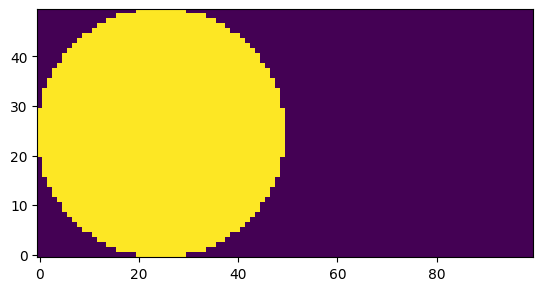

In [17]:
# show domain slice
plt.imshow(sim._boundaries[-1].mask[:,:,0].T, origin="lower")

In [18]:
#vram_history_file.close()

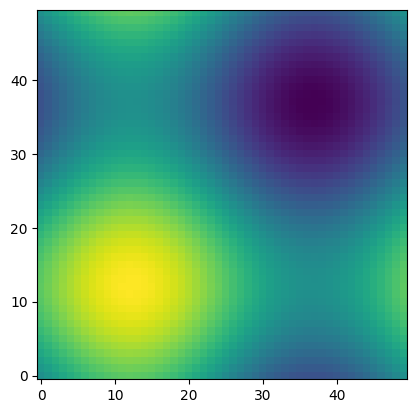

In [19]:
# show pertubation in x=1 slice
plt.imshow(lattice.convert_to_numpy(lattice.u(sim.f))[0,1,:,:], origin="lower")

In [20]:
### grid reynolds number
print(re_g)

4.000000000000001


# export Parameters

In [21]:
### export parameters

if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   SIM-Parameters   ###")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nT_target = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\nDpX (D/X) = " + str(domain_length_in_D))
    output_file.write("\nDpY (D/Y) = "+str(domain_height_in_D))
    if lattice.D == 3:
        output_file.write("\nDpZ (D/Z) = "+str(domain_width_in_D))
    output_file.write("\nshape_LU: "+ str(flow.shape))
    output_file.write(("\ntotal_number_of_gridpoints: "+str(lattice.rho(sim.f).numel())))
    output_file.write("\nbc_type = "+str(bc_type))
    output_file.write("\nlateral_walls = "+str(lateral_walls))
    output_file.write("\nstencil = "+str(stencil_choice))
    output_file.write("\ncollision = " + str(collision_choice))
    output_file.write("\n")
    output_file.write("\nMa = " + str(Ma))
    output_file.write("\ntau = " + str(tau))
    output_file.write("\ngrid_reynolds_number (Re_g) = " + str(re_g))
    output_file.write("\n")
    output_file.write("\nsetup_diameter_PU = " + str(setup_diameter))
    output_file.write("\nflow_velocity_PU = " + str(flow_velocity))
    output_file.write("\nu_init = " + str(u_init))
    output_file.write("\nperturb_init = " + str(perturb_init))
    output_file.write("\n")
    output_file.write("\noutput_vtk = " + str(output_vtk))
    output_file.write("\nvtk_fps = " + str(vtk_fps))
    output_file.close()

# export obstacle geometry

GPD = 50
area_rel: 1.0063685361586725


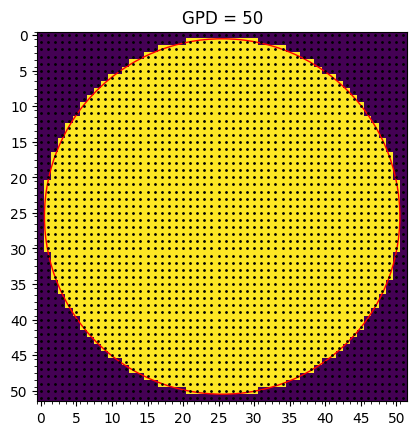

In [30]:
### calculate and export 2D obstacle_mask as .png
grid_x = gridpoints_per_diameter+2
if output_data:
    output_file = open(output_path+dir_name +"/"+timestamp + "_obstacle_mask_info.txt", "a")
    output_file.write("GPD = " + str(gridpoints_per_diameter)+"\n")
print("GPD = " + str(gridpoints_per_diameter))
# define radius and position for a symetrical circular Cylinder-Obstacle
radius_LU = 0.5 * gridpoints_per_diameter
y_pos_LU = 0.5 * grid_x + 0.5
x_pos_LU = y_pos_LU

# get x,y,z meshgrid of the domain (LU)
xyz = tuple(np.linspace(1, n, n) for n in (grid_x,grid_x))  # Tupel aus Listen indizes (1-n (nicht 0-based!))
xLU, yLU = np.meshgrid(*xyz, indexing='ij')  # meshgrid aus den x-, y- (und z-)Indizes -> * damit man die einzelnen Einträge des Tupels übergibt, und nicht das eine Tupel

# define cylinder (LU)
obstacle_mast_for_visualization = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU

nx, ny = obstacle_mast_for_visualization.shape  # Anzahl x-Punkte, Anzahl y-Punkte (Skalar), (der gesamten Domain)

rand_mask = np.zeros((nx, ny), dtype=bool)  # für Randpunkte, die es gibt
rand_mask_f = np.zeros((lattice.Q, nx, ny), dtype=bool)  # für Randpunkte (inkl. Q-Dimension)
rand_xq = []  # Liste aller x Werte (inkl. q-multiplizität)
rand_yq = []  # Liste aller y Werte (inkl. q-multiplizität)

a, b = np.where(obstacle_mast_for_visualization)  # np.array: Liste der (a) x-Koordinaten  und (b) y-Koordinaten der obstacle_mast_for_visualization
# ...um über alle Boundary/Objekt/Wand-Knoten iterieren zu können
for p in range(0, len(a)):  # für alle TRUE-Punkte der obstacle_mast_for_visualization
    for i in range(0, lattice.Q):  # für alle stencil-Richtungen c_i (hier lattice.stencil.e)
        try:  # try in case the neighboring cell does not exist (an f pointing out of the simulation domain)
            if not obstacle_mast_for_visualization[a[p] + lattice.stencil.e[i, 0], b[p] + lattice.stencil.e[i, 1]]:
                # falls in einer Richtung Punkt+(e_x, e_y; e ist c_i) False ist, ist das also ein Oberflächenpunkt des Objekts (selbst True mit Nachbar False)
                rand_mask[a[p], b[p]] = 1
                rand_mask_f[lattice.stencil.opposite[i], a[p], b[p]] = 1
                rand_xq.append(a[p])
                rand_yq.append(b[p])
        except IndexError:
            pass  # just ignore this iteration since there is no neighbor there
rand_x, rand_y = np.where(rand_mask)  # Liste aller Rand-x- und y-Koordinaten
x_pos = sum(rand_x)/len(rand_x)  # x_Koordinate des Kreis-Zentrums
y_pos = sum(rand_y)/len(rand_y)  # y-Koordinate des Kreis-Zentrums

# calculate all radii and r_max and r_min
r_max = 0
r_min = gridpoints_per_diameter
radii = np.zeros_like(rand_x, dtype=float)  # Liste aller Radien (ohne q) in LU
for p in range(0, len(rand_x)):  # für alle Punkte
    radii[p] = np.sqrt((rand_x[p]-x_pos)**2 + (rand_y[p]-y_pos)**2)  # berechne Abstand des Punktes zum Zentrum
    if radii[p] > r_max:
        r_max = radii[p]
    if radii[p] < r_min:
        r_min = radii[p]

# calculate all radii (with q-multiplicity)
radii_q = np.zeros_like(rand_xq, dtype=float)
for p in range(0, len(rand_xq)):
    radii_q[p] = np.sqrt((rand_xq[p]-x_pos)**2 + (rand_yq[p]-y_pos)**2)

### all relative radii in relation to gpd/2
radii_relative = radii / (radius_LU-0.5)  # (substract 0.5 because "true" boundary location is 0.5LU further out than node-coordinates)
radii_q_relative = radii_q / (radius_LU-0.5)

# calc. mean rel_radius
r_rel_mean = sum(radii_relative)/len(radii_relative)
rq_rel_mean = sum(radii_q_relative)/len(radii_q_relative)

## AREA calculation
area_theory = np.pi*(gridpoints_per_diameter/2)**2  # area = pi*r² in LU²
area = len(a)  # area in LU = number of nodes, because every node has a cell of 1LU x 1LU around it

if output_data:
    output_file.write("\nr_rel_mean: " + str(sum(radii_relative)/len(radii_relative)))
    output_file.write("\nrq_rel_mean: " + str(sum(radii_q_relative)/len(radii_q_relative)))
    output_file.write("\nr_rel_min: " + str(r_max/(radius_LU-0.5)))
    output_file.write("\nr_rel_max: " + str(r_min/(radius_LU-0.5)))
    output_file.write("\n\narea_rel: " + str(area/area_theory))

    from collections import Counter
    output_file.write("\n\nradii: " + str(Counter(radii)))
    output_file.write("\nradii_q: " + str(Counter(radii_q))+"\n\n")
    output_file.close()

print("area_rel: " + str(area/area_theory))

### PLOT Mask
plt.figure()
plt.imshow(obstacle_mast_for_visualization)
#plt.xticks(np.arange(gridpoints_per_diameter + 2), minor=True)
#plt.yticks(np.arange(gridpoints_per_diameter + 2), minor=True)
ax = plt.gca()
xmin, xmax = ax.get_xlim()
ymax, ymin = ax.get_ylim()
if gridpoints_per_diameter >= 10:
    plt.xticks(np.arange(0, xmax, int(xmax/10)))
    plt.yticks(np.arange(0, ymax, int(ymax/10)))
else:
    plt.xticks(np.arange(0, xmax, 1))
    plt.yticks(np.arange(0, ymax, 1))
plt.title("GPD = "+str(gridpoints_per_diameter))
ax.set_xticks(np.arange(-.5, xmax, 1), minor=True)
ax.set_yticks(np.arange(-.5, ymax, 1), minor=True)

# grid thickness
# if gridpoints_per_diameter < 30:
#     ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=2)
# elif gridpoints_per_diameter < 70:
#     ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=1)
# elif gridpoints_per_diameter < 100:
#     ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=0.5)
# elif gridpoints_per_diameter < 150:
#     ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=0.25)

# draw ideal circle
circle = plt.Circle((xmax/2-0.25, ymax/2-0.25), gridpoints_per_diameter/2, color='r', fill=False)
ax.add_patch(circle)

# draw nodes
x,y = np.meshgrid(np.linspace(0,int(xmax), int(xmax+1)), np.linspace(0,int(ymax),int(ymax+1)))
plt.plot(x,y, marker='.', linestyle='', color="k", markersize=2)

if output_data:
    plt.savefig(output_path+dir_name +"/"+timestamp + "obtacle_mask_GPD" + str(gridpoints_per_diameter) + ".png")

plt.show()

In [23]:
print("numel d_gt (>0.5):", sim._boundaries[-1].d_sequential_gt.numel())
print("numel d_lt (<=0.5):", sim._boundaries[-1].d_sequential_lt.numel())
print("d_lt:", sim._boundaries[-1].d_sequential_lt)
print("d_gt:", sim._boundaries[-1].d_sequential_gt)

numel d_gt (>0.5): 34800
numel d_lt (<=0.5): 26400
d_lt: tensor([-49.9083, -49.9083, -49.9083,  ...,   0.5000,   0.5000,   0.5000],
       device='cuda:0', dtype=torch.float64)
d_gt: tensor([0.5251, 0.5251, 0.5251,  ..., 0.9226, 0.8881, 0.8881], device='cuda:0',
       dtype=torch.float64)


GPD = 30
area_rel: 1.012932793367085


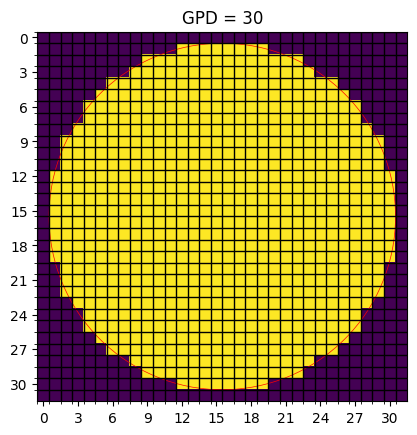

In [29]:
from lettuce.max import draw_circular_mask

draw_circular_mask(lattice, 30, output_data=True, print_data=True, filebase=output_path+dir_name +"/"+timestamp)

# SIMULATION

In [20]:
### simple simulation

t_start=time.time()

mlups = sim.step(n_steps) #simulation

t_end=time.time()
runtime=t_end-t_start
print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds (", round(runtime/60,2),"minutes )")

c_time = sim.time_avg["time_collision"]
s_time = sim.time_avg["time_streaming"]
b_time = sim.time_avg["time_boundary"]
r_time = sim.time_avg["time_reporter"]
sum_time = sim.time_avg["time_collision"] + sim.time_avg["time_streaming"] + sim.time_avg["time_boundary"] + sim.time_avg["time_reporter"]

print("collision avg. time:", sim.time_avg["time_collision"], "seconds (" + str(round(100 * c_time/sum_time, 2)) + " %)")
print("streaming avg. time:", sim.time_avg["time_streaming"], "seconds (" + str(round(100 * s_time/sum_time, 2)) + " %)")
print("boundary avg. time:", sim.time_avg["time_boundary"], "seconds (" + str(round(100 * b_time/sum_time, 2)) + " %)")
print("reporter avg. time:", sim.time_avg["time_reporter"], "seconds (" + str(round(100 * r_time/sum_time, 2)) + " %)")

print("current GPU VRAM (MB): ", torch.cuda.memory_allocated(device="cuda:0")/1024/1024)
print("max. GPU VRAM (MB): ", torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024)

[cpuLoad1,cpuLoad5,cpuLoad15] = [x / psutil.cpu_count() * 100 for x in psutil.getloadavg()]
print("CPU % avg. over last 1 min, 5 min, 15 min; ", round(cpuLoad1,2), round(cpuLoad5,2), round(cpuLoad15,2))

ram = psutil.virtual_memory()
print("current total RAM usage [MB]: " + str(round(ram.used/(1024*1024),2)) + " of " + str(round(ram.total/(1024*1024),2)) + " MB")

MLUPS: 4.858697410978326
PU-Time:  0.0018042195912175807  seconds
number of steps: 1
runtime:  0.5060970783233643 seconds ( 0.01 minutes )
collision avg. time: 0.002874985999369528 seconds (0.58 %)
streaming avg. time: 0.0013201049987401348 seconds (0.26 %)
boundary avg. time: 0.0031846240017330274 seconds (0.64 %)
reporter avg. time: 0.491389786999207 seconds (98.52 %)
current GPU VRAM (MB):  575.4248046875
max. GPU VRAM (MB):  575.767578125
CPU % avg. over last 1 min, 5 min, 15 min;  1.09 0.93 0.7
current total RAM usage [MB]: 8351.52 of 64220.0 MB


In [21]:
a = sim._boundaries[-1].f_mask_sequential_lt
#a = torch.index_select(a, 1, torch.tensor([0], device="cuda:0"))

#sim.f_collided[a]
print(a[:,0])
#sim.f[lattice.stencil.opposite[a[0,0]]]
#lattice.stencil.opposite
bnd = sim._boundaries[-1]

# print("d_seq:\n",bnd.d_sequential)
# print("d_seq_gt:\n",bnd.d_sequential_gt)
# print("d_seq_lt:\n",bnd.d_sequential_lt)
# print("d_seq_where<=0.5\n", lattice.convert_to_tensor(bnd.d_sequential)[torch.where(lattice.convert_to_tensor(bnd.d_sequential[:,4])<=0.5)])
# print("lattice.opposite:\n", bnd.lattice.stencil.opposite)
# print("opposite tensor:\n", bnd.opposite_tensor)
# #print("TW:", torch.where(lattice.convert_to_tensor(bnd.d_sequential)<=0.5))
print("f_mask_seq\n", bnd.f_mask_sequential_gt)
#print("where f_mask\n",torch.where(bnd.f_mask))

tensor([17, 23, 25,  ..., 18, 24, 26], device='cuda:0')
f_mask_seq
 tensor([[ 1, 71, 77,  0],
        [ 3, 72, 76,  0],
        [ 7, 72, 76, 47],
        ...,
        [22, 88, 83, 46],
        [24, 88, 81,  0],
        [26, 88, 81, 46]], device='cuda:0')


In [22]:
# # f_mask identisch?
# f_mask2 = lattice.convert_to_tensor(np.zeros(bnd.f_mask.shape, dtype=bool))
# print(f_mask2)
# f_mask2[bnd.f_mask_sequential_gt[:,0], bnd.f_mask_sequential_gt[:,1], bnd.f_mask_sequential_gt[:,2], bnd.f_mask_sequential_gt[:,3]] = True
# f_mask2[bnd.f_mask_sequential_lt[:,0], bnd.f_mask_sequential_lt[:,1], bnd.f_mask_sequential_lt[:,2], bnd.f_mask_sequential_lt[:,3]] = True
# f_mask_diff = f_mask2 == bnd.f_mask
# torch.where(f_mask_diff==False)



In [23]:
if logVRAM:
    log_VRAM("END log")
    vram_history_file.write("\n\n" + "GP: " + str(gridpoints) + "\nD: " + str(lattice.D) + "\nQ: " + str(lattice.Q) + "\n")
    vram_history_file.write("\nTENSORS: \nDimensions x GP; Size [MB]; Candidates:"
                            + "\n"+"Qd: ".rjust(4) + str(round(gridpoints*lattice.Q*8/(1024*1024),2)).rjust(10) + "; f, f_collided, d, f_tmp, tmp"
                            + "\n"+"Qb: ".rjust(4) + str(round(gridpoints*lattice.Q*1/(1024*1024),2)).rjust(10) + "; f_mask, no_streaming_mask"
                            + "\n"+"d: ".rjust(4) + str(round(gridpoints*8/(1024*1024),2)).rjust(10) + "; rho, p"
                            + "\n"+"b: ".rjust(4) + str(round(gridpoints*1/(1024*1024),2)).rjust(10) + "; no_collision_mask"
                            + "\n"+"Dd: ".rjust(4) + str(round(gridpoints*lattice.D*8/(1024*1024),2)).rjust(10)  + "; u"
                            + "\n")
    vram_history_file.close()

In [24]:
### export stats
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_stats.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   SIM-STATS  ###")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\navg. Collision-Time [s] = " + str(c_time) + " (" + str(round(100 * c_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Streaming-Time [s] = " + str(s_time) + " (" + str(round(100 * s_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Boundary-Time  [s] = " + str(b_time) + " (" + str(round(100 * b_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Reporter-Time  [s] = " + str(r_time) + " (" + str(round(100 * r_time/sum_time, 2)) + " %)")
    output_file.write("\n")
    output_file.write("\nVRAM_current [MB] = " + str(torch.cuda.memory_allocated(lattice.device)/1024/1024))
    output_file.write("\nVRAM_peak [MB] = " + str(torch.cuda.max_memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n")
    output_file.write("\nCPU load % avg. over last 1, 5, 15 min: " + str(round(cpuLoad1, 2)) + " %, " + str(round(cpuLoad5, 2)) + " %, " + str(round(cpuLoad15, 2)) + " %")
    output_file.write("\ntotal current RAM usage [MB]: " + str(round(ram.used/(1024*1024),2)) + " of " + str(round(ram.total/(1024*1024),2)) + " MB")
    output_file.close()

In [25]:
# # Output Clock
#
# print("Clock:")
# print(np.array(Clock.out))

# Avg Velocity

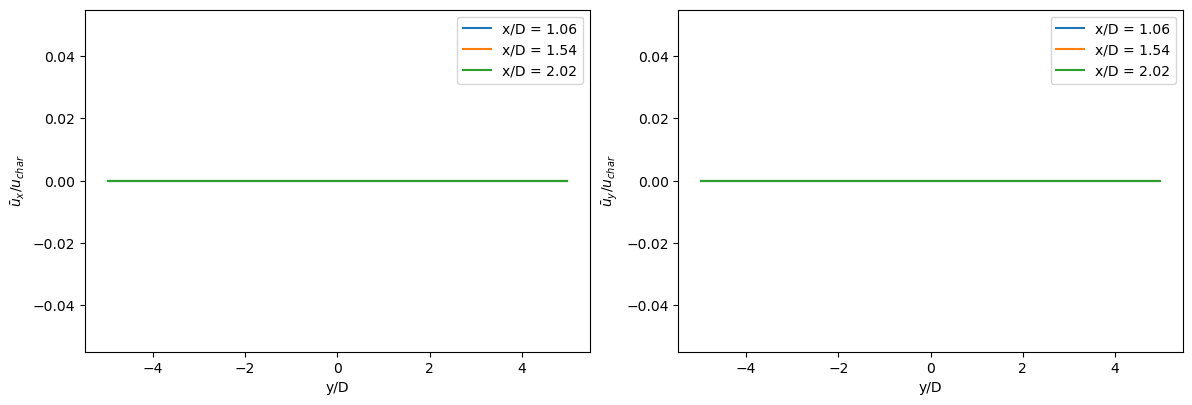

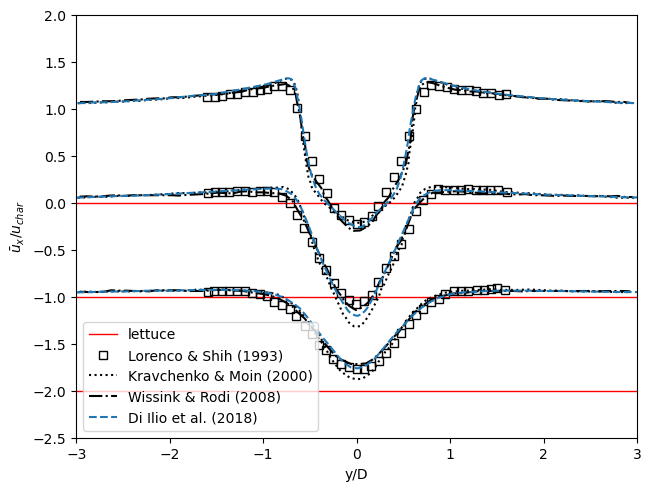

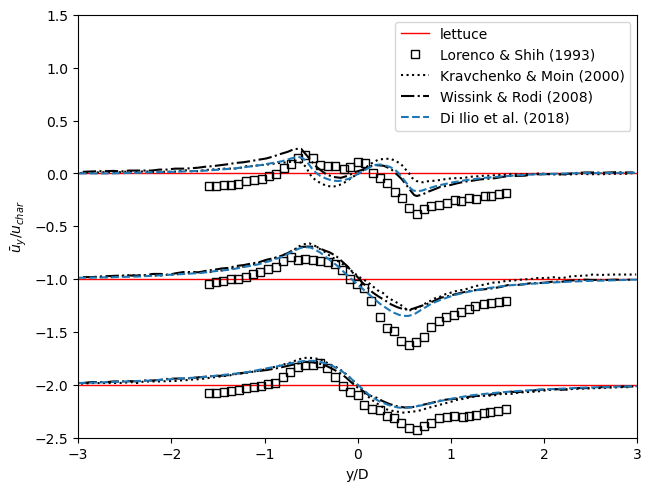

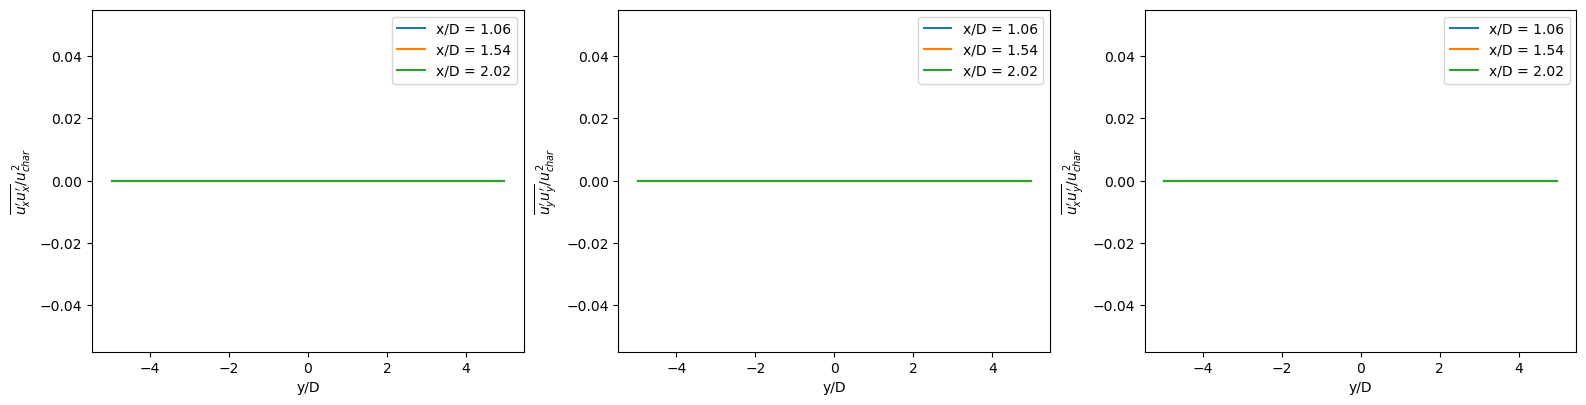

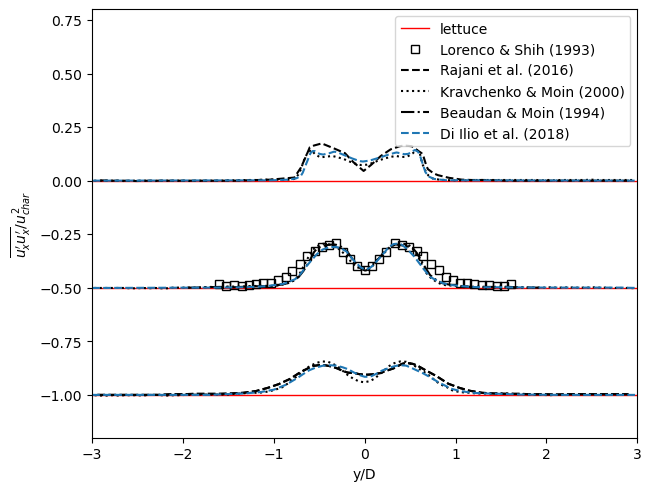

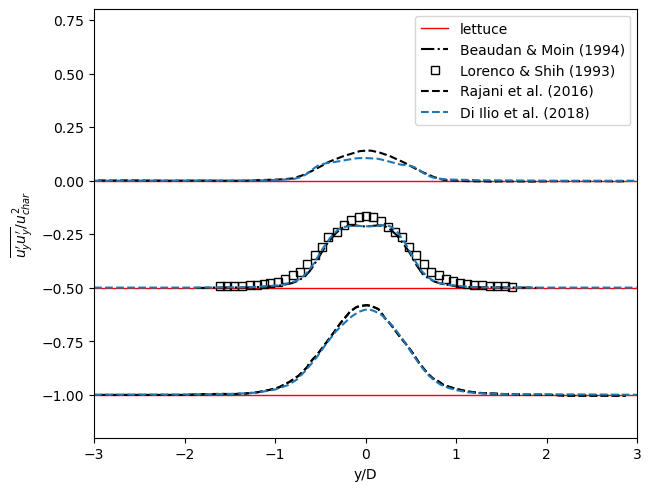

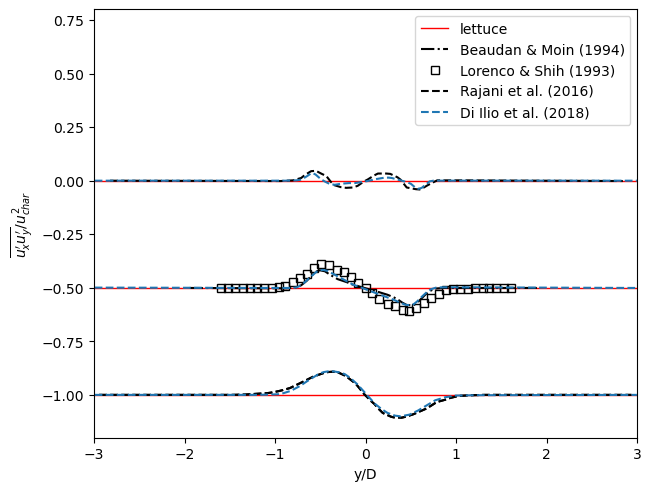

In [26]:
# plot AvgVelocity (ist per Reporter schon in PU, normalisierung mit u_char nicht nötig, da u_char = 1 in PU)

if calculate_velocity_profile:
    avg_u_start = 0.5

    # import reference data: (data is: first collumn Y/D, second column u_d/u_char)
    # ux
    p1_LS1993_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos1_LS1993.csv', delimiter=';')
    p2_LS1993_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos2_LS1993.csv', delimiter=';')
    p3_LS1993_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos3_LS1993.csv', delimiter=';')

    p1_KM2000_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos1_KM2000.csv', delimiter=';')
    p2_KM2000_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos2_KM2000.csv', delimiter=';')
    p3_KM2000_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos3_KM2000.csv', delimiter=';')

    p1_WR2008_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos1_WR2008.csv', delimiter=';')
    p2_WR2008_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos2_WR2008.csv', delimiter=';')
    p3_WR2008_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos3_WR2008.csv', delimiter=';')

    p1_DI2018_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos1_DI2018.csv', delimiter=';')
    p2_DI2018_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos2_DI2018.csv', delimiter=';')
    p3_DI2018_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos3_DI2018.csv', delimiter=';')

    # uy
    p1_LS1993_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos1_LS1993.csv', delimiter=';')
    p2_LS1993_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos2_LS1993.csv', delimiter=';')
    p3_LS1993_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos3_LS1993.csv', delimiter=';')

    p1_KM2000_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos1_KM2000.csv', delimiter=';')
    p2_KM2000_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos2_KM2000.csv', delimiter=';')
    p3_KM2000_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos3_KM2000.csv', delimiter=';')

    p1_WR2008_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos1_WR2008.csv', delimiter=';')
    p2_WR2008_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos2_WR2008.csv', delimiter=';')
    p3_WR2008_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos3_WR2008.csv', delimiter=';')

    p1_DI2018_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos1_DI2018.csv', delimiter=';')
    p2_DI2018_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos2_DI2018.csv', delimiter=';')
    p3_DI2018_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos3_DI2018.csv', delimiter=';')

    # uxux
    p1_DI2018_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos1_DI2018.csv', delimiter=';')
    p1_KM2000_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos1_KM2000.csv', delimiter=';')
    p1_R2016_uxux  = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos1_R2016.csv', delimiter=';')
    p2_BM1994_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_BM1994.csv', delimiter=';')
    p2_DI2018_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_DI2018.csv', delimiter=';')
    p2_KM2000_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_KM2000.csv', delimiter=';')
    p2_LS1993_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_LS1993.csv', delimiter=';')
    p2_R2016_uxux  = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_R2016.csv', delimiter=';')
    p3_DI2018_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos3_DI2018.csv', delimiter=';')
    p3_KM2000_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos3_KM2000.csv', delimiter=';')
    p3_R2016_uxux  = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos3_R2016.csv', delimiter=';')

    # uyuy
    p1_DI2018_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos1_DI2018.csv', delimiter=';')
    p1_R2016_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos1_R2016.csv', delimiter=';')
    p2_BM1994_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos2_BM1994.csv', delimiter=';')
    p2_DI2018_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos2_DI2018.csv', delimiter=';')
    p2_LS1993_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos2_LS1993.csv', delimiter=';')
    p2_R2016_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos2_R2016.csv', delimiter=';')
    p3_DI2018_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos3_DI2018.csv', delimiter=';')
    p3_R2016_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos3_R2016.csv', delimiter=';')

    # uxuy
    p1_BM1994_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos1_BM1994.csv', delimiter=';')
    p1_DI2018_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos1_DI2018.csv', delimiter=';')
    p1_R2016_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos1_R2016.csv', delimiter=';')
    p2_BM1994_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos2_BM1994.csv', delimiter=';')
    p2_DI2018_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos2_DI2018.csv', delimiter=';')
    p2_LS1993_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos2_LS1993.csv', delimiter=';')
    p2_R2016_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos2_R2016.csv', delimiter=';')
    p3_BM1994_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos3_BM1994.csv', delimiter=';')
    p3_DI2018_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos3_DI2018.csv', delimiter=';')
    p3_R2016_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos3_R2016.csv', delimiter=';')

    # output sim data to files (not averaged over time)
    if output_data and output_velocity_profile:
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_timeseries.npy", np.array(AvgVelocity1.out))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_timeseries.npy", np.array(AvgVelocity2.out))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_timeseries.npy", np.array(AvgVelocity3.out))

    u1 = np.array(AvgVelocity1.out)[int(avg_u_start*np.array(AvgVelocity1.out).shape[0]-1):]
    u2 = np.array(AvgVelocity2.out)[int(avg_u_start*np.array(AvgVelocity2.out).shape[0]-1):]
    u3 = np.array(AvgVelocity3.out)[int(avg_u_start*np.array(AvgVelocity3.out).shape[0]-1):]

    avg_u1 = np.mean(u1, axis=0)  # time average
    avg_u2 = np.mean(u2, axis=0)  # time average
    avg_u3 = np.mean(u3, axis=0)  # time average

    if output_data:  # output (time-mean) velocity profiles
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_t-avg.npy", avg_u1)
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_t-avg.npy", avg_u2)
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_t-avg.npy", avg_u3)

    avg_u1_x = avg_u1[0]  # u_x component over y at pos 1
    avg_u2_x = avg_u2[0]  # u_x component over y at pos 2
    avg_u3_x = avg_u3[0]  # u_x component over y at pos 3

    avg_u1_y = avg_u1[1]  # u_y component over y at pos 1
    avg_u2_y = avg_u2[1]  # u_y component over y at pos 2
    avg_u3_y = avg_u3[1]  # u_y component over y at pos 3

    y_in_D = (np.arange(avg_u1_x.shape[0])+1-flow.y_pos)/flow.units.characteristic_length_lu  # y/D for figure
    if output_data:
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_YinD.npy", y_in_D)
    cm=1/2.54
    # PLOT ux
    fig, (ax_ux, ax_uy) = plt.subplots(1,2, constrained_layout=True, figsize=(30*cm,10*cm))
    ax_ux.plot(y_in_D,avg_u1_x, y_in_D, avg_u2_x, y_in_D, avg_u3_x)
    ax_ux.set_xlabel("y/D")
    ax_ux.set_ylabel(r"$\bar{u}_{x}$/$u_{char}$")
    ax_ux.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])

    # OPT. TO DO: add secondary axis for LU-grid
    # ...needs 'function' to convert from y/D in LU and LU in y/D

    # OPT. TO DO: make folder for AvgVelocity-stuff
    # if output_data:
    #     plt.savefig(output_path+dir_name+"/AvgVelocity_x.png")
    # plt.show()

    # PLOT uy
    #fig, ax = plt.subplots(constrained_layout=True)
    ax_uy.plot(y_in_D,avg_u1_y, y_in_D, avg_u2_y, y_in_D, avg_u3_y)
    ax_uy.set_xlabel("y/D")
    ax_uy.set_ylabel(r"$\bar{u}_{y}$/$u_{char}$")
    ax_uy.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])

    # OPT. TO DO: add secondary axis for LU-grid
    # ...needs 'function' to convert from y/D in LU and LU in y/D
    # OPT. TO DO: make folder for AvgVelocity-stuff
    # !!! QUESTION: is x/D the position measured FROM the cylinder (x_pos), or measured from x=0 ?

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_velocity_noReference.png")
    plt.show()

    # PLOT ux against references
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,avg_u1_x, y_in_D, avg_u2_x-1, y_in_D, avg_u3_x-2)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_LS = ax.plot(p1_LS1993_ux[:,0], p1_LS1993_ux[:,1], p2_LS1993_ux[:,0], p2_LS1993_ux[:,1], p3_LS1993_ux[:,0], p3_LS1993_ux[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_KM = ax.plot(p1_KM2000_ux[:,0], p1_KM2000_ux[:,1], p2_KM2000_ux[:,0], p2_KM2000_ux[:,1], p3_KM2000_ux[:,0], p3_KM2000_ux[:,1])
    plt.setp(ref_KM, ls="dotted", lw=1.5, marker="", color="k", label="Kravchenko & Moin (2000)")
    ref_WR = ax.plot(p1_WR2008_ux[:,0], p1_WR2008_ux[:,1], p2_WR2008_ux[:,0], p2_WR2008_ux[:,1], p3_WR2008_ux[:,0], p3_WR2008_ux[:,1])
    plt.setp(ref_WR, ls="dashdot", lw=1.5, marker="", color="k", label="Wissink & Rodi (2008)")
    ref_DI = ax.plot(p1_DI2018_ux[:,0], p1_DI2018_ux[:,1], p2_DI2018_ux[:,0], p2_DI2018_ux[:,1], p3_DI2018_ux[:,0], p3_DI2018_ux[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\bar{u}_{x}$/$u_{char}$")
    ax.set_ylim([-2.5,+2])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_LS[0], ref_KM[0], ref_WR[0], ref_DI[0]], loc= 'best')
    #ax_ux.text(-3, 1.5, "x/D = 1.06", fontstile='italic')
    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_ux_withReference.png")
    plt.show()

    # PLOT uy against references
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,avg_u1_y, y_in_D, avg_u2_y-1, y_in_D, avg_u3_y-2)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_LS = ax.plot(p1_LS1993_uy[:,0], p1_LS1993_uy[:,1], p2_LS1993_uy[:,0], p2_LS1993_uy[:,1], p3_LS1993_uy[:,0], p3_LS1993_uy[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_KM = ax.plot(p1_KM2000_uy[:,0], p1_KM2000_uy[:,1], p2_KM2000_uy[:,0], p2_KM2000_uy[:,1], p3_KM2000_uy[:,0], p3_KM2000_uy[:,1])
    plt.setp(ref_KM, ls="dotted", lw=1.5, marker="", color="k", label="Kravchenko & Moin (2000)")
    ref_WR = ax.plot(p1_WR2008_uy[:,0], p1_WR2008_uy[:,1], p2_WR2008_uy[:,0], p2_WR2008_uy[:,1], p3_WR2008_uy[:,0], p3_WR2008_uy[:,1])
    plt.setp(ref_WR, ls="dashdot", lw=1.5, marker="", color="k", label="Wissink & Rodi (2008)")
    ref_DI = ax.plot(p1_DI2018_uy[:,0], p1_DI2018_uy[:,1], p2_DI2018_uy[:,0], p2_DI2018_uy[:,1], p3_DI2018_uy[:,0], p3_DI2018_uy[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\bar{u}_{y}$/$u_{char}$")
    ax.set_ylim([-2.5,+1.5])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_LS[0], ref_KM[0], ref_WR[0], ref_DI[0]], loc= 'best')
    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_uy_withReference.png")
    plt.show()

    ## turbulent Reynolds stresses

    # diff between timeseries and time_average -> u'
    u1_diff = u1-avg_u1
    u2_diff = u2-avg_u2
    u3_diff = u3-avg_u3

    # square of diff -> u'^2
    u1_diff_sq = u1_diff**2
    u2_diff_sq = u2_diff**2
    u3_diff_sq = u3_diff**2

    # ux'*uy'
    u1_diff_xy = u1_diff[:, 0, :]*u1_diff[:, 1, :]
    u2_diff_xy = u2_diff[:, 0, :]*u2_diff[:, 1, :]
    u3_diff_xy = u3_diff[:, 0, :]*u3_diff[:, 1, :]

    # time_average of u'² and ux'uy'
    u1_diff_sq_mean = np.mean(u1_diff_sq, axis=0)  # time average
    u2_diff_sq_mean = np.mean(u2_diff_sq, axis=0)  # time average
    u3_diff_sq_mean = np.mean(u3_diff_sq, axis=0)  # time average
    u1_diff_xy_mean = np.mean(u1_diff_xy, axis=0)  # time average
    u2_diff_xy_mean = np.mean(u2_diff_xy, axis=0)  # time average
    u3_diff_xy_mean = np.mean(u3_diff_xy, axis=0)  # time average

    if output_data:  # save reynolds stresses
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_ReStress_x.npy", np.array([y_in_D, u1_diff_sq_mean[0]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_ReStress_x.npy", np.array([y_in_D, u2_diff_sq_mean[0]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_ReStress_x.npy", np.array([y_in_D, u3_diff_sq_mean[0]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_ReStress_y.npy", np.array([y_in_D, u1_diff_sq_mean[1]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_ReStress_y.npy", np.array([y_in_D, u2_diff_sq_mean[1]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_ReStress_y.npy", np.array([y_in_D, u3_diff_sq_mean[1]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_ReShearStress.npy", np.array([y_in_D, u1_diff_xy_mean]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_ReShearStress.npy", np.array([y_in_D, u2_diff_xy_mean]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_ReShearStress.npy", np.array([y_in_D, u3_diff_xy_mean]))


    fig, (ax_xx, ax_yy, ax_xy) = plt.subplots(1,3, figsize=(40*cm,10*cm), constrained_layout=True)
    ax_xx.plot(y_in_D,u1_diff_sq_mean[0],y_in_D,u2_diff_sq_mean[0],y_in_D,u3_diff_sq_mean[0])
    ax_xx.set_xlabel("y/D")
    ax_xx.set_ylabel(r"$\overline{u_{x}'u_{x}'}$/$u_{char}^2$")
    ax_xx.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
    # if output_data:
    #     plt.savefig(output_path+dir_name+"/AvgVelocity_uxux.png")
    # plt.show()

    #fig, ax = plt.subplots(constrained_layout=True)
    ax_yy.plot(y_in_D,u1_diff_sq_mean[1], y_in_D,u2_diff_sq_mean[1], y_in_D,u3_diff_sq_mean[1])
    ax_yy.set_xlabel("y/D")
    ax_yy.set_ylabel(r"$\overline{u_{y}'u_{y}'}$/$u_{char}^2$")
    ax_yy.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
    # if output_data:
    #     plt.savefig(output_path+dir_name+"/AvgVelocity_uyuy.png")
    # plt.show()

    #fig, ax = plt.subplots(constrained_layout=True)
    ax_xy.plot(y_in_D,u1_diff_xy_mean, y_in_D,u2_diff_xy_mean, y_in_D,u3_diff_xy_mean)
    ax_xy.set_xlabel("y/D")
    ax_xy.set_ylabel(r"$\overline{u_{x}'u_{y}'}$/$u_{char}^2$")
    ax_xy.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_reynoldsStresses_noReference.png")
    plt.show()

    #plot reynolds stresses against reference
    # uxux - streamwise
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,u1_diff_sq_mean[0], y_in_D, u2_diff_sq_mean[0]-0.5, y_in_D, u3_diff_sq_mean[0]-1)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_LS = ax.plot(p2_LS1993_uxux[:,0], p2_LS1993_uxux[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_R = ax.plot(p1_R2016_uxux[:,0], p1_R2016_uxux[:,1], p3_R2016_uxux[:,0], p3_R2016_uxux[:,1], p3_R2016_uxux[:,0], p3_R2016_uxux[:,1])
    plt.setp(ref_R, ls="--", lw=1.5, marker="", color="k", label="Rajani et al. (2016)")
    ref_KM = ax.plot(p1_KM2000_uxux[:,0], p1_KM2000_uxux[:,1], p2_KM2000_uxux[:,0], p2_KM2000_uxux[:,1], p3_KM2000_uxux[:,0], p3_KM2000_uxux[:,1])
    plt.setp(ref_KM, ls="dotted", lw=1.5, marker="", color="k", label="Kravchenko & Moin (2000)")
    ref_BM = ax.plot(p2_BM1994_uxux[:,0], p2_BM1994_uxux[:,1])
    plt.setp(ref_BM, ls="dashdot", lw=1.5, marker="", color="k", label="Beaudan & Moin (1994)")
    ref_DI = ax.plot(p1_DI2018_uxux[:,0], p1_DI2018_uxux[:,1], p2_DI2018_uxux[:,0], p2_DI2018_uxux[:,1], p3_DI2018_uxux[:,0], p3_DI2018_uxux[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\overline{u_{x}'u_{x}'}$/$u_{char}^2$")
    ax.set_ylim([-1.2,0.8])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_LS[0], ref_R[0], ref_KM[0], ref_BM[0], ref_DI[0]], loc= 'best')

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_uxux_withReference.png")
    plt.show()

    # uyuy - cross-stream
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,u1_diff_sq_mean[1], y_in_D, u2_diff_sq_mean[1]-0.5, y_in_D, u3_diff_sq_mean[1]-1)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_BM = ax.plot(p2_BM1994_uyuy[:,0], p2_BM1994_uyuy[:,1])
    plt.setp(ref_BM, ls="dashdot", lw=1.5, marker="", color="k", label="Beaudan & Moin (1994)")
    ref_LS = ax.plot(p2_LS1993_uyuy[:,0], p2_LS1993_uyuy[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_R = ax.plot(p1_R2016_uyuy[:,0], p1_R2016_uyuy[:,1], p3_R2016_uyuy[:,0], p3_R2016_uyuy[:,1], p3_R2016_uyuy[:,0], p3_R2016_uyuy[:,1])
    plt.setp(ref_R, ls="--", lw=1.5, marker="", color="k", label="Rajani et al. (2016)")
    ref_DI = ax.plot(p1_DI2018_uyuy[:,0], p1_DI2018_uyuy[:,1], p2_DI2018_uyuy[:,0], p2_DI2018_uyuy[:,1], p3_DI2018_uyuy[:,0], p3_DI2018_uyuy[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\overline{u_{y}'u_{y}'}$/$u_{char}^2$")
    ax.set_ylim([-1.2,0.8])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_BM[0], ref_LS[0], ref_R[0], ref_DI[0]], loc='best')

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_uyuy_withReference.png")
    plt.show()

    # uxuy - Reynolds shear stress
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,u1_diff_xy_mean, y_in_D, u2_diff_xy_mean-0.5, y_in_D, u3_diff_xy_mean-1)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_BM = ax.plot(p2_BM1994_uxuy[:,0], p2_BM1994_uxuy[:,1])
    plt.setp(ref_BM, ls="dashdot", lw=1.5, marker="", color="k", label="Beaudan & Moin (1994)")
    ref_LS = ax.plot(p2_LS1993_uxuy[:,0], p2_LS1993_uxuy[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_R = ax.plot(p1_R2016_uxuy[:,0], p1_R2016_uxuy[:,1], p3_R2016_uxuy[:,0], p3_R2016_uxuy[:,1], p3_R2016_uxuy[:,0], p3_R2016_uxuy[:,1])
    plt.setp(ref_R, ls="--", lw=1.5, marker="", color="k", label="Rajani et al. (2016)")
    ref_DI = ax.plot(p1_DI2018_uxuy[:,0], p1_DI2018_uxuy[:,1], p2_DI2018_uxuy[:,0], p2_DI2018_uxuy[:,1], p3_DI2018_uxuy[:,0], p3_DI2018_uxuy[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\overline{u_{x}'u_{y}'}$/$u_{char}^2$")
    ax.set_ylim([-1.2,0.8])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_BM[0], ref_LS[0], ref_R[0], ref_DI[0]], loc='best')

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_uxuy_withReference.png")
    plt.show()

    # (!) standard plot/figure size in python is 6.4 x 4.8 inches

In [27]:
# # test velocity fluctuations (mittlere quadratische Abweichung vom zeitlichen mittel)
# # 1. u_i' = u_i - u_mean
# # 2. (ux')^2
# # 3. zeitliches mitte (ux')^2
#
# print(u1.shape)
# print(avg_u1.shape)
#
# u1_diff = u1-avg_u1
# print(u1_diff.shape)
#
# u1_diff_sq = u1_diff**2
# u1_diff_xy = u1_diff_sq[:,0,:]*u1_diff[:,1,:]
# print(u1_diff_sq.shape)
# print("u1_diff_xy_shape:", u1_diff_xy.shape)
#
# u1_diff_sq_mean = np.mean(u1_diff_sq, axis=0)  # time average
# u1_diff_xy_mean = np.mean(u1_diff_xy, axis=0)  # time average
#
# print("u1\n",u1[:,0,50])
# print("avg_u1\n", avg_u1[0,50])
# print("u1_diff\n", u1_diff[:,0,50])
# print("u1_diff_sq_mean\n", u1_diff_sq_mean[0,50])
#
# fig, ax = plt.subplots(constrained_layout=True)
# ax.plot(y_in_D,u1_diff_sq_mean[0])
# ax.set_xlabel("y/D")
# ax.set_ylabel(r"$\overline{u_{x}'u_{x}'}$/$u_{char}^2$")
# ax.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
# plt.show()
#
# fig, ax = plt.subplots(constrained_layout=True)
# ax.plot(y_in_D,u1_diff_sq_mean[1])
# ax.set_xlabel("y/D")
# ax.set_ylabel(r"$\overline{u_{y}'u_{y}'}$/$u_{char}^2$")
# ax.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
# plt.show()
#
# fig, ax = plt.subplots(constrained_layout=True)
# ax.plot(y_in_D,u1_diff_xy_mean)
# ax.set_xlabel("y/D")
# ax.set_ylabel(r"$\overline{u_{x}'u_{y}'}$/$u_{char}^2$")
# ax.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
# plt.show()

In [28]:
#print(y_in_D)

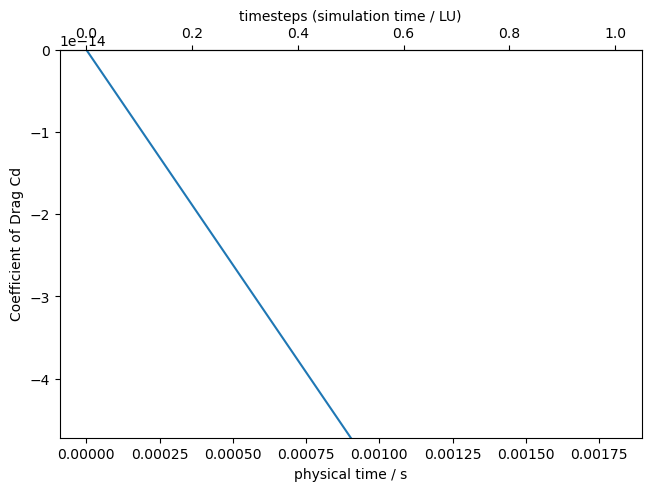

In [29]:
### plot Drag coefficient

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])
ax.set_ylim([0.5,3])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:  # save plot with standard y limits
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")

ax.set_ylim([drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()*0.5,drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()*1.2])
if output_data:  # save plot with adjusted y limits
    plt.savefig(output_path+dir_name+"/drag_coefficient_adjusted.png")
plt.show()

In [30]:
### calculate mean drag_coefficient in periodic region:
try:
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]

    peaks_max = find_peaks(values, prominence=((values.max()-values.min())/2))
    peaks_min = find_peaks(-values, prominence=((values.max()-values.min())/2))
    # find peaks only works correctly, if simulation is converged in the periodic region...

    if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
        peak_number = peaks_max[0].shape[0]
    else:
        peak_number = peaks_min[0].shape[0]

    if peaks_min[0][0] < peaks_max[0][0]:
        first_peak = peaks_min[0][0]
        last_peak = peaks_max[0][peak_number-1]
    else:
        first_peak = peaks_max[0][0]
        last_peak = peaks_min[0][peak_number-1]

    drag_mean = values[first_peak:last_peak].mean()
    drag_mean_simple = values.mean()

    print("Cd, simple mean:     ",drag_mean_simple)
    print("Cd, peak_finder mean:",drag_mean)
    print("start time of 'mean'-ing:",drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1])
    ## plotting peaks from peak_finder:
    drag_stepsLU = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,0]
    peak_max_y = values[peaks_max[0]]
    peak_max_x = drag_stepsLU[peaks_max[0]]
    peak_min_y = values[peaks_min[0]]
    peak_min_x = drag_stepsLU[peaks_min[0]]

    plt.plot(drag_stepsLU, values)
    plt.scatter(peak_max_x[:peak_number],peak_max_y[:peak_number])
    plt.scatter(peak_min_x[:peak_number],peak_min_y[:peak_number])
    plt.scatter(drag_stepsLU[first_peak],values[first_peak])
    plt.scatter(drag_stepsLU[last_peak],values[last_peak])
    if output_data:
        plt.savefig(output_path+dir_name+"/drag_coefficient_peakfinder.png")
    peakfinder=True
except:
    print("peak-finding didn't work... probably no significant peaks visible (Re<46?), or periodic region not reached (T too small)")
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]
    drag_mean_simple = values.mean()
    peakfinder=False
    print("Cd, simple mean:",drag_mean_simple)

peak-finding didn't work... probably no significant peaks visible (Re<46?), or periodic region not reached (T too small)
Cd, simple mean: -4.718447915510281e-14


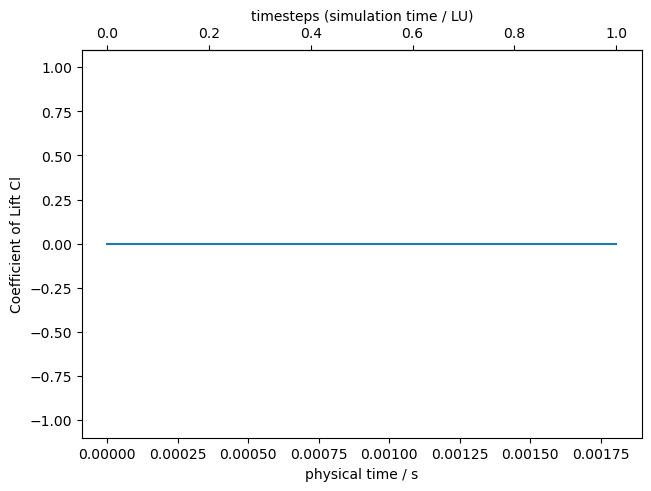

Cl_peaks: 
min 0.0 
max 0.0


In [31]:
### plot Lift coefficient

lift_coefficient = np.array(Liftreport.out)
# print('  stepLU        ', 'timePU        ', 'Cl')
# print(lift_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_coefficient[:,1],lift_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Lift Cl")
ax.set_ylim([-1.1,1.1])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/lift_coefficient.png")
    np.savetxt(output_path+dir_name+"/lift_coefficient.txt", lift_coefficient, header="stepLU  |  timePU  |  Cl  FROM str(timestamp)")
plt.show()

Cl_min = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].min()
Cl_max = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].max()

print("Cl_peaks: \nmin", Cl_min,"\nmax", Cl_max)

Strouhal-calculation failed, check simulation data


/tmp/ipykernel_16290/2174943580.py:17: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())   # ylim, where highes peak is on left half of full spectrum


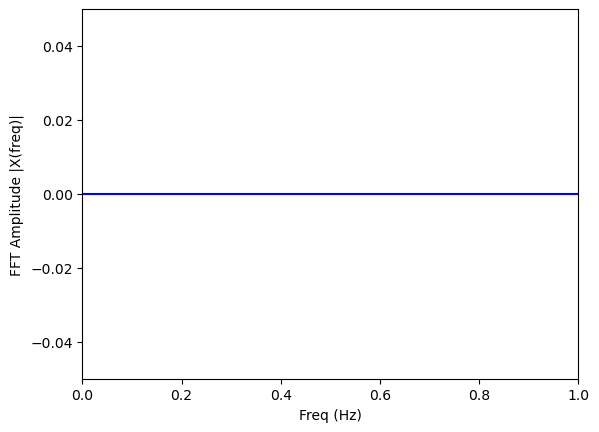

In [32]:
### prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.

try:
    X = np.fft.fft(lift_coefficient[:,2])   # fft result (amplitudes)
    N = len(X)  # number of freqs
    n = np.arange(N)   # freq index
    T = N*flow.units.convert_time_to_pu(1)   # total time measured (T_PU)
    freq = n/T   # frequencies (x-axis of spectrum)

    plt.figure
    plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")   # plot spectrum |X|(f)
    plt.xlabel("Freq (Hz)")
    plt.ylabel("FFT Amplitude |X(freq)|")
    plt.xlim(0,1)
    #print("max. Amplitude np.abx(X).max():", np.abs(X).max())   # for debugging
    plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())   # ylim, where highes peak is on left half of full spectrum

    if output_data:
        plt.savefig(output_path+dir_name+"/fft_Cl.png")

    freq_res = freq[1]-freq[0]   # frequency-resolution
    X_abs = np.abs(X[:int(X.shape[0]*0.4)])   # get |X| Amplitude for left half of full spectrum
    freq_peak = freq[np.argmax(X_abs)]    # find frequency with the highest amplitude
    print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
    # f = Strouhal for St=f*D/U and D=U=1 in PU
except:
    print("Strouhal-calculation failed, check simulation data")
    freq_res=0
    freq_peak=0

In [33]:
# save notebook to simulation_output
if output_data:
    try:
        shutil.copy(str(os.getcwd())+"/cylinder3D_development_v2.ipynb",output_path+dir_name+"/script.ipynb")
    except:
        print("script could not be saved")
else:
    print("output_data-toggle is FALSE")

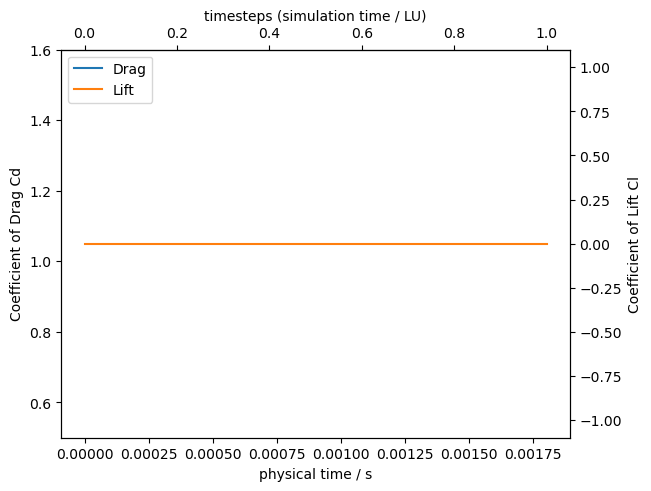

In [34]:
### plot Drag coefficient AND Lift Coefficient

fig, ax = plt.subplots(layout="constrained")
drag_ax = ax.plot(drag_coefficient[:,1],drag_coefficient[:,2], color="tab:blue", label="Drag")
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")

ax2 = ax.twinx()
lift_ax = ax2.plot(lift_coefficient[:,1],lift_coefficient[:,2], color="tab:orange", label="Lift")
ax2.set_ylabel("Coefficient of Lift Cl")
ax2.set_ylim([-1.1,1.1])


fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

if output_data:
    plt.savefig(output_path+dir_name+"/dragAndLift_coefficient.png")

plt.show()

In [35]:
### Analysis of GPU memory usage (tensors)

if output_data:
### cudas own memory summary
    print(torch.cuda.memory_summary(device="cuda:0"))
    ### CUDA-VRAM-summary:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_memory_summary.txt", "a")
    output_file.write("DATA for "+timestamp+"\n\n")
    output_file.write(torch.cuda.memory_summary(device="cuda:0"))
    output_file.close()

### list present torch tensors:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt", "a")
    total_bytes = 0
    import gc
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obj.data)):
                output_file.write("\n"+str(obj.size())+", "+str(obj.nelement()*obj.element_size()))
                total_bytes = total_bytes+obj.nelement()*obj.element_size()
        except:
            pass
    #output_file.write("\n\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

### count occurence of tensors in list of tensors:
    from collections import Counter
    my_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt","r")
    data=my_file.read()
    my_file.close()
    data_into_list=data.split("\n")
    c = Counter(data_into_list)
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_counted_tensors.txt", "a")
    for k,v in c.items():
        output_file.write("type,size,bytes: {}, number: {}\n".format(k,v) )
    output_file.write("\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  589235 KB |  589235 KB |   19946 MB |   19371 MB |
|       from large pool |  588000 KB |  588000 KB |   19931 MB |   19357 MB |
|       from small pool |    1235 KB |    1235 KB |      15 MB |      13 MB |
|---------------------------------------------------------------------------|
| Active memory         |  589235 KB |  589235 KB |   19946 MB |   19371 MB |
|       from large pool |  588000 KB |  588000 KB |   19931 MB |

/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [36]:
# output data
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parms_stats_obs.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   SIM-Parameters   ###")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nT_target = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\nDpX (D/X) = " + str(domain_length_in_D))
    output_file.write("\nDpY (D/Y) = "+str(domain_height_in_D))
    if lattice.D == 3:
        output_file.write("\nDpZ (D/Z) = "+str(domain_width_in_D))
    output_file.write("\nshape_LU: "+ str(flow.shape))
    output_file.write(("\ntotal_number_of_gridpoints: "+str(lattice.rho(sim.f).numel())))
    output_file.write("\nbc_type = "+str(bc_type))
    output_file.write("\nlateral_walls = "+str(lateral_walls))
    output_file.write("\nstencil = "+str(stencil_choice))
    output_file.write("\ncollision = " + str(collision_choice))
    output_file.write("\n")
    output_file.write("\nMa = " + str(Ma))
    output_file.write("\ntau = " + str(tau))
    output_file.write("\ngrid_reynolds_number (Re_g) = " + str(re_g))
    output_file.write("\n")
    output_file.write("\nsetup_diameter_PU = " + str(setup_diameter))
    output_file.write("\nflow_velocity_PU = " + str(flow_velocity))
    output_file.write("\nu_init = " + str(u_init))
    output_file.write("\nperturb_init = " + str(perturb_init))
    output_file.write("\n")
    output_file.write("\noutput_vtk = " + str(output_vtk))
    output_file.write("\nvtk_fps = " + str(vtk_fps))

    output_file.write("\n\n###   SIM-STATS  ###")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\navg. Collision-Time [s] = " + str(c_time) + " (" + str(round(100 * c_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Streaming-Time [s] = " + str(s_time) + " (" + str(round(100 * s_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Boundary-Time  [s] = " + str(b_time) + " (" + str(round(100 * b_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Reporter-Time  [s] = " + str(r_time) + " (" + str(round(100 * r_time/sum_time, 2)) + " %)")
    output_file.write("\n")
    output_file.write("\nVRAM_current [MB] = " + str(torch.cuda.memory_allocated(lattice.device)/1024/1024))
    output_file.write("\nVRAM_peak [MB] = " + str(torch.cuda.max_memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n")
    output_file.write("\nCPU load % avg. over last 1, 5, 15 min: " + str(round(cpuLoad1, 2)) + " %, " + str(round(cpuLoad5, 2)) + " %, " + str(round(cpuLoad15, 2)) + " %")
    output_file.write("\ntotal current RAM usage [MB]: " + str(round(ram.used/(1024*1024),2)) + " of " + str(round(ram.total/(1024*1024),2)) + " MB")

    output_file.write("\n\n###   OBSERVABLES   ###")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\nCd_mean, simple      = "+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\nCd_mean, peak_finder = "+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\nCd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\nCd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\nCoefficient of lift:")
    output_file.write("\nCl_min = "+str(Cl_min))
    output_file.write("\nCl_max = "+str(Cl_max))
    output_file.write("\n")
    output_file.write("\nStrouhal number:")
    output_file.write("\nSt +- df = "+str(freq_peak)+" +- "+str(freq_res)+" Hz")
    output_file.write("\n")
    output_file.close()


In [37]:
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parms_stats_obs_copyable.txt", "a")

    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   Data:   ###")
    output_file.write("\nRe, n_steps, t_target(PU), GPD, DpX, DpY, (DpZ), shape_LU, gridpoints, bc_type, lateral_walls, stencil, collision, Ma, tau, Re_grid, setup_diameter_PU, flow_velocity_PU, u_init, perturb_init, output_vtk, vtk_fps, runtime, MLUPS, c_time, s_time, b_time, r_time, VRAM_current_MB, VRAM_peak_MB, periodic_start, Cd_mean, Cd_mean_pf, Cd_min, Cd_max, Cl_min, Cl_max, St, df")
    output_file.write("\n" + str(re))
    output_file.write("\n" + str(n_steps))
    output_file.write("\n" + str(flow.units.convert_time_to_pu(n_steps)))
    output_file.write("\n" + str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\n" + str(domain_length_in_D))
    output_file.write("\n" + str(domain_height_in_D))
    if lattice.D == 3:
        output_file.write("\n" + str(domain_width_in_D))
    output_file.write("\n" + str(flow.shape))
    output_file.write("\n" + str(lattice.rho(sim.f).numel()))
    output_file.write("\n"+str(bc_type))
    output_file.write("\n"+str(lateral_walls))
    output_file.write("\n"+str(stencil_choice))
    output_file.write("\n" + str(collision_choice))
    output_file.write("\n")
    output_file.write("\n" + str(Ma))
    output_file.write("\n" + str(tau))
    output_file.write("\n" + str(re_g))
    output_file.write("\n")
    output_file.write("\n" + str(setup_diameter))
    output_file.write("\n" + str(flow_velocity))
    output_file.write("\n" + str(u_init))
    output_file.write("\n" + str(perturb_init))
    output_file.write("\n")
    output_file.write("\n" + str(output_vtk))
    output_file.write("\n" + str(vtk_fps))
    output_file.write("\n")

    output_file.write("\n"+str(runtime))
    output_file.write("\n"+str(mlups))
    output_file.write("\n")
    output_file.write("\n" + str(c_time))
    output_file.write("\n" + str(s_time))
    output_file.write("\n" + str(b_time))
    output_file.write("\n" + str(r_time))
    output_file.write("\n")
    output_file.write("\n" + str(torch.cuda.memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n" + str(torch.cuda.max_memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n")

    output_file.write("\n" + str(periodic_start))
    output_file.write("\n"+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\n"+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\n"+str(Cl_min))
    output_file.write("\n"+str(Cl_max))
    output_file.write("\n")
    output_file.write("\n"+str(freq_peak))
    output_file.write("\n"+str(freq_res))
    output_file.write("\n")
    output_file.close()

In [38]:
print("current VRAM (MB): ", torch.cuda.memory_allocated(device="cuda:0")/1024/1024)
print("max. VRAM (MB): ", torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024)

current VRAM (MB):  575.4248046875
max. VRAM (MB):  594.1748046875
